In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
# Suppress specific FutureWarnings from pandas or other libraries
warnings.filterwarnings("ignore", category=FutureWarning)

In [55]:
class SingleFactorBacktester:
    def __init__(self, prices, factors, benchmark, factor_name, start_value=100000, transaction_cost = 0.003,
                 long_short = True, num_layers=5, short_ratio=0.2, long_ratio=0.2, holding_window=20, 
                 rolling_window = 20, rf_rate = 0.3, start_date=None, end_date=None, Stop_Loss=True):
        
        self.tra_cost = transaction_cost
        self.rolling_window = rolling_window
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        adjusted_start_date = self.start_date - pd.Timedelta(days=self.rolling_window)
        self.prices = prices[adjusted_start_date:self.end_date]
        self.factors = factors[adjusted_start_date:self.end_date]
        self.benchmark = benchmark[adjusted_start_date:self.end_date]
        self.Stop_Loss = Stop_Loss
        if len(self.prices) <=20 or len(self.factors)<=20:
            return "Backtesting dates are less then lower limit!"
        self.rf_rate = rf_rate
        self.factor_name = factor_name
        self.start_value = start_value
        self.long_ratio = long_ratio
        self.short_ratio = short_ratio
        self.num_layers = num_layers
        self.holding_window = holding_window
        self.long_short = long_short
        self.log_df = pd.DataFrame(index=self.prices.index)
        self.log_df = self.log_df[adjusted_start_date:self.end_date]
        self.log_df['signals'] = self.factors.copy()
        self.performance_metrics = pd.DataFrame()



    ################# compute signals here ####################
    def compute_signals(self, window_size=20,IS_test = False,layer = 1):
        """
        Compute trading signals based on the factor values.
        :param window_size: Size of the rolling window for calculating signals based on quantiles.
        """

                        # Define a function to calculate signals within the rolling window
        def calculate_signals(x):
            upper_quantile = np.quantile(x[:-1], 1-self.long_ratio)
            lower_quantile = np.quantile(x[:-1], self.short_ratio)
            # Assign signals based on quantile thresholds
            if x[-1] >= upper_quantile:
                return 1
            elif x[-1] <= lower_quantile:
                return -1
            else:
                return 0
        def calculate_signals_2(x):
            upper_quantile = np.quantile(x[:-1], 1-self.long_ratio)
            # Assign signals based on quantile thresholds
            if x[-1] >= upper_quantile:
                return 1
            else:
                return 0

        if not IS_test:
            self.log_df['signals'] = 0
            if self.long_short:
                # Calculate signals using the rolling window apply method
                self.log_df['signals'] = self.factors.rolling(window=window_size).apply(calculate_signals, raw=False)
            else:

                self.log_df['signals'] = self.factors.rolling(window=window_size).apply(calculate_signals_2, raw=False)
        if IS_test:
            log_df =  pd.DataFrame(index=self.log_df.index)
            # log_df['signals'] = self.factors.rolling(window=window_size).apply(calculate_signals_2, raw=False)
            log_df['signals'] = np.where(self.log_df['factor_layer']==layer, 1, 0)
            return log_df


    def execute_trades(self,IS_test = False,layer_num = 1):
        """
        Execute trades based on the computed signals.
        """
        if not IS_test:
            # self.compute_signals()
            self.log_df['positions'] = 0
            i = 0 
            while i < len(self.log_df):
                signal = self.log_df['signals'].iloc[i]
                nextt = min(self.holding_window,len(self.log_df)-i)
                self.log_df.loc[self.log_df.index[i:i + nextt], 'positions'] = signal
                i += nextt


            data_tem = pd.merge(self.log_df['positions'].shift(1),self.prices.pct_change(),on='Dates', how='inner')
            data_tem['daily_returns_before'] = data_tem['positions']*data_tem[self.prices.columns[0]]
            data_tem['transaction_cost'] = self.tra_cost * abs(data_tem['positions'] - data_tem['positions'].shift(1))
            data_tem['daily_returns'] = data_tem['daily_returns_before'] - data_tem['transaction_cost']

            self.log_df['daily_returns'] = data_tem['daily_returns']
            self.log_df = self.log_df.dropna()
            self.log_df['cumPnL'] = (1 + self.log_df['daily_returns']).cumprod()
            self.log_df['portfolio_value'] = self.log_df['daily_returns'].cumsum() + self.start_value
            self.log_df['portfolio_value'] = (self.start_value * (1 + self.log_df['daily_returns'])).cumprod()

        if IS_test:
            # log_df = self.compute_signals(IS_test = True,layer =layer_num)
            log_df = self.log_df.copy()
            log_df['signals'] = np.where(self.log_df['factor_layer']==layer_num,self.log_df['signals'] , 0)

            log_df['positions'] = 0
            i = 0 
            while i < len(log_df):
                signal = log_df['signals'].iloc[i]
                nextt = min(self.holding_window,len(log_df)-i)
                log_df.loc[log_df.index[i:i + nextt], 'positions'] = signal
                i += nextt
            # price_returns = self.prices.pct_change()
            # common_index = price_returns.index.intersection(log_df.index)
            # price_returns = price_returns.loc[common_index]
            # while i < len(log_df):
            #     signal = log_df['signals'].iloc[i]
            #     if signal in [1, -1]:
            #         nextt = min(self.holding_window, len(log_df) - i)
            #         log_df.loc[log_df.index[i:i + nextt], 'positions'] = signal
            #         if self.Stop_Loss:
            #             for n in range(1, nextt):
            #                 if i + n < len(log_df):
            #                     start_return = price_returns.iloc[i].item()
            #                     current_return = price_returns.iloc[i + n].item()
            #                     # Stop Loss where the drop in daily_return exceeds 10%
            #                     if start_return!=0 and (start_return - current_return) / start_return > 0.10:
            #                         log_df.loc[log_df.index[i + n:], 'positions'] = 0
            #                         nextt = n+5
            #                         break
            #         i += nextt
            #     else:
            #         i += 1
            data_tem = pd.merge(log_df['positions'].shift(1),self.prices.pct_change(),on='Dates', how='inner')
            data_tem['daily_returns_before'] = data_tem['positions']*data_tem[self.prices.columns[0]]
            data_tem['transaction_cost'] = self.tra_cost * abs(data_tem['positions'] - data_tem['positions'].shift(1))
            data_tem['daily_returns'] = data_tem['daily_returns_before'] - data_tem['transaction_cost']

            return data_tem['daily_returns'].dropna()

    def calculate_performance(self):
        """
        Calculate various performance metrics.
        """
        self.log_df['rolling_IC'] = 0
        self.log_df['rolling_IR'] = 0
        self.log_df['rolling_sharpe_ratio'] = 0
        returns = self.prices.pct_change().fillna(0)
        returns = returns.reindex(self.log_df.index)

        for t in range(120, len(self.log_df)):
            signal_to_t = self.log_df['positions'].iloc[t-120:t]
            returns_to_t = returns.iloc[t-120:t,0]
            signal_returns_to_t =(1+self.log_df['daily_returns'].iloc[t-120:t]).cumprod()-1
            if (signal_to_t == 0).sum() == len(signal_to_t):
                continue

            if signal_to_t.std() > 0.00001 and returns_to_t.std() > 0.00001:
                self.log_df.loc[self.log_df.index[t], 'rolling_IC'] = signal_to_t.corr(returns_to_t)

            if (signal_returns_to_t - returns_to_t).std() is not None:
                self.log_df.loc[self.log_df.index[t], 'rolling_IR'] = (signal_returns_to_t - returns_to_t).mean() / (signal_returns_to_t - returns_to_t).std()

            if (signal_returns_to_t - self.rf_rate/252*120).std() > 0.001: 
                self.log_df.loc[self.log_df.index[t], 'rolling_sharpe_ratio'] = (signal_returns_to_t - self.rf_rate/252*120).mean() / (signal_returns_to_t - self.rf_rate/252*120).std()
            
            else:
                self.log_df.loc[self.log_df.index[t], 'rolling_sharpe_ratio'] = self.log_df.loc[self.log_df.index[t-120], 'rolling_sharpe_ratio']

        self.log_df['turnover_rate'] = abs(self.log_df['positions'] - self.log_df['positions'].shift(1))/self.log_df['positions'].shift(1)
        self.log_df['turnover_rate'] = self.log_df['turnover_rate'].replace([float('inf'), -float('inf')], 1)
        self.log_df['turnover_rate'] = self.log_df['turnover_rate'].fillna(0) 
        
        daily_returns = self.log_df['daily_returns'].dropna()
        original_returns = self.prices.pct_change()
        benchmark_returns = self.benchmark.pct_change()
        strategy_annual_cumulative_return = ((1 + daily_returns).cumprod() - 1).iloc[-1].item()
        observed_days = len(daily_returns)
        strategy_annual_cumulative_return  = (1 + strategy_annual_cumulative_return) ** (252 / observed_days) - 1


        strategy_annual_return = np.mean(daily_returns) * 252
        benchmark_annual_return = (benchmark_returns.mean() * 252).item()
        benchmark_annual_cumulative_return = ((1 + benchmark_returns).cumprod() - 1).iloc[-1].item()
        benchmark_annual_cumulative_return  = (1 + benchmark_annual_cumulative_return) ** (252 / observed_days) - 1
        strategy_annual_volatility = np.std(daily_returns) * np.sqrt(252)
        benchmark_volatility = (benchmark_returns.std() * np.sqrt(252)).item()
        
        benchmark_sharpe = (benchmark_annual_return - self.rf_rate)/ benchmark_volatility

        corr_df = pd.merge(original_returns, self.factors,how='outer',on='Dates').dropna()
        ic = np.corrcoef(corr_df.iloc[:,0],corr_df.iloc[:,1])[0, 1]

        exc_df = pd.merge(daily_returns, benchmark_returns,how='outer',on='Dates').dropna()
        excess_returns =exc_df.iloc[:,0] - exc_df.iloc[:,1]
        excess_annual_return = np.mean(excess_returns)* 252
        excess_annual_cumulative_returns = ((1+exc_df.iloc[:,0] - exc_df.iloc[:,1]).cumprod() - 1)[-1]
        excess_annual_cumulative_returns  = (1 + excess_annual_cumulative_returns) ** (252 / observed_days) - 1
        strategy_annual_volatility_sharpe_based = (daily_returns - self.rf_rate/252).std()* np.sqrt(252)
        sharpe_ratio = (strategy_annual_cumulative_return  - self.rf_rate)/ strategy_annual_volatility_sharpe_based
        ir = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)

        strategy_max = (1 + daily_returns).cumprod()
        running_max = strategy_max.cummax()
        self.log_df['drawdown'] = (strategy_max - running_max) / running_max
        max_drawdown = self.log_df['drawdown'].min()*100

        # Calculate win rate
        win_rate = (daily_returns > 0).sum() / len(daily_returns) *100

        # Calculate Sortino ratio
        downside_risk = np.std(daily_returns[daily_returns < 0]) * np.sqrt(252)
        sortino_ratio = strategy_annual_return / downside_risk

        self.performance_metrics = pd.DataFrame([{
            "Factor Name" : self.factor_name,
            "Holding Window": self.holding_window,
            # "Strategy Annual Return %": strategy_annual_return * 100,
            "Strategy Annual Cumulative Return %": strategy_annual_cumulative_return* 100,
            # "Benchmark Annual Return %": benchmark_annual_return* 100,
            "Long NG1 Annual Cumulative Return %": benchmark_annual_cumulative_return* 100,
            # "Excess Annual Return %": excess_annual_return* 100,
            "Excess Annual Cumulative Return %": excess_annual_cumulative_returns* 100,
            "Strategy Annual Sharpe Ratio": sharpe_ratio,
            "Long NG1 Sharpe Ratio": benchmark_sharpe,
            "Strategy Annual Volatility": strategy_annual_volatility,
            "Long NG1 Annual Volatility": benchmark_volatility,
            "Max Drawdown %": max_drawdown,
            "Win Rate %": win_rate,
            "Annual Sortino Ratio": sortino_ratio,
            "Information Coefficient (IC)": ic,
            "Information Ratio (IR)": ir,
            'Turnover Rate': self.log_df['turnover_rate'].mean()
        }])

    def layer_test(self):
        """
        Perform a layer test by dividing the factor values into quantiles and
        calculating cumulative returns for each layer.
        """

        def find_quantile_layer(window, num_layers):
            if len(window) < 2:  # Not enough data to rank
                return np.nan 
            quantiles = pd.qcut(-window, q=num_layers, labels=False, duplicates="drop")
            return quantiles.iloc[-1]  # 找到最后一个值的分层位置
        self.log_df['factor_layer'] =self.factors.rolling(window=self.rolling_window, min_periods=1).apply(
            lambda x: find_quantile_layer(pd.Series(x), self.num_layers), raw=False
        )

        # self.log_df['factor_layer'] = pd.qcut(fa, q=self.num_layers, labels=False, duplicates='drop')
        bench_re = self.benchmark[['Close']].pct_change().dropna()
        bench_re = (1+bench_re).cumprod()-1
        # Set up the plot
        plt.figure(figsize=(10, 6))

        percentile_labels = [f"{int(i * 100 / self.num_layers)}% - {int((i + 1) * 100 / self.num_layers)}%" for i in range(self.num_layers)]

        # Plot cumulative returns for each factor layer
        for i, layer in enumerate(sorted(self.log_df['factor_layer'].unique())):
            returns = self.execute_trades(IS_test=True, layer_num=layer)

            cum_returns = (1 + returns).cumprod() - 1
            plt.plot(cum_returns.index, cum_returns, label=f'Layer {layer + 1} (Top {percentile_labels[int(layer)]})')

        # Plot benchmark returns
        plt.plot(bench_re.index, bench_re, label='Long NG1 Cumulative Returns', color='black', linestyle='--')

        # Customize and display the plot
        plt.legend(title='Quantile Ranges', title_fontsize='13', fontsize='11')
        plt.title(f'{self.factor_name}\'s Cumulative Returns by Factor Layer', fontsize=14)
        plt.xlabel('Time', fontsize=12)
        plt.ylabel(f'{self.factor_name}\'s Cumulative Returns', fontsize=12)
        plt.grid(True)
        plt.show()

    def return_plots(self):
        plt.style.use('ggplot')

        daily_returns = self.log_df['daily_returns'].dropna()
        original_returns = self.prices.pct_change().dropna()
        benchmark_returns = self.benchmark.pct_change().dropna()

        strategy_monthly_returns = (1 + daily_returns).resample('M').prod() - 1
        benchmark_monthly_returns = (1 + benchmark_returns.iloc[:,0]).resample('M').prod() - 1
        original_monthly_returns = (1 + original_returns.iloc[:,0]).resample('M').prod() - 1

        strategy_annual_cumulative_return = ((1 + daily_returns).cumprod())
        original_annual_cumulative_return = ((1 + original_returns).cumprod())
        benchmark_annual_cumulative_return = ((1 + benchmark_returns).cumprod())
        common_index = strategy_monthly_returns.index.intersection(
            benchmark_monthly_returns.index.intersection(original_monthly_returns.index)
        )
        strategy_monthly_returns = strategy_monthly_returns.loc[common_index]
        benchmark_monthly_returns = benchmark_monthly_returns.loc[common_index]
        original_monthly_returns = original_monthly_returns.loc[common_index]
        plt.figure(figsize=(14, 8))
        bar_width = 0.25
        group_spacing = 0.5 
        positions = np.arange(len(strategy_monthly_returns)) * (bar_width * 3 + group_spacing)
        # Plot strategy monthly returns
        plt.bar(
            positions - bar_width,
            strategy_monthly_returns,
            width=bar_width,
            color='skyblue',
            edgecolor='black',
            label="Strategy Returns"
        )

        # # Plot benchmark monthly returns
        # plt.bar(
        #     positions,
        #     benchmark_monthly_returns,
        #     width=bar_width,
        #     color='orange',
        #     edgecolor='black',
        #     label="Benchmark Returns"
        # )

        # Plot original monthly returns
        plt.bar(
            positions + bar_width,
            original_monthly_returns,
            width=bar_width,
            color='green',
            edgecolor='black',
            label="Long NG1 Returns"
        )

        plt.title(f'{self.factor_name}\'s Monthly Returns Comparison', fontsize=16, fontweight='bold')
        plt.xlabel("Month", fontsize=12)
        plt.ylabel("Returns", fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.xticks(
            ticks=positions[::5],
            labels=strategy_monthly_returns.index[::5].strftime('%b-%Y'),
            rotation=45,
            fontsize=10
        )
        plt.legend(loc="upper left", fontsize=12)
        plt.tight_layout()
        plt.show()




        plt.figure(figsize=(14, 8))

        # Plot strategy monthly returns
        plt.plot(
            # strategy_annual_cumulative_return.index,
            strategy_annual_cumulative_return,
            label="Strategy Returns",
            color='skyblue',

        )


        # Plot benchmark monthly returns
        # plt.plot(
        #     benchmark_annual_cumulative_return.index,
        #     benchmark_annual_cumulative_return,
        #     label="Benchmark Returns",
        #     color='orange',
        # )

        # Plot original monthly returns
        plt.plot(
            # original_annual_cumulative_return.index,
            original_annual_cumulative_return,
            label="Long NG1 Returns",
            color='green',
        )

        # Add a title and labels

        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Limit to 10 major ticks
        plt.gca().xaxis.set_minor_locator(plt.MaxNLocator(20))  # Optional: Add minor ticks
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

        # Add labels and legend
        plt.xlabel("Dates")
        plt.ylabel("Returns")
        plt.title(f'{self.factor_name}\'s Strategy Annual Cumulative Returns')
        plt.legend()
        # plt.title("Returns Line Chart Comparison", fontsize=16, fontweight='bold')
        # plt.xlabel("Dates", fontsize=12)
        # plt.ylabel("Returns", fontsize=12)
        # plt.grid(axis='y', linestyle='--', alpha=0.6)

        # # Set x-axis ticks
        # plt.xticks(
        #     ticks=strategy_monthly_returns.index,
        #     labels=strategy_monthly_returns.index.strftime('%b-%Y'),
        #     rotation=45,
        #     fontsize=10
        # )


        # plt.legend(loc="upper left", fontsize=12)
        plt.tight_layout()
        plt.show()


        # plot 3: Rolling plot for indicators

        # plt.style.use('ggplot')
        plt.figure(figsize=(20, 15))
        colors = sns.color_palette("muted")

        # Plot Turnover Rate
        plt.subplot(4, 1, 1)
        plt.bar(
            positions + bar_width,
            original_monthly_returns,
            width=bar_width,
            color='green',
            edgecolor='black',
            label="Long NG1 Returns"
        )
        plt.bar(
            positions - bar_width,
            strategy_monthly_returns,
            width=bar_width,
            color='skyblue',
            edgecolor='black',
            label="Strategy Returns"
        )
        plt.title(f'{self.factor_name}\'s Monthly Returns Comparison', fontsize=16, fontweight='bold')
        plt.xlabel("Month", fontsize=12)
        plt.ylabel("Returns", fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.xticks(
            ticks=positions[::5],
            labels=strategy_monthly_returns.index[::5].strftime('%b-%Y'),
            rotation=45,
            fontsize=10
        )
        plt.legend(loc="upper left", fontsize=12)
        plt.tight_layout()
        # plt.show()

        plt.subplot(4, 1, 2)
        plt.plot(self.log_df['turnover_rate'], label='Turnover Rate', color=colors[0], linewidth=2)
        plt.title(f'{self.factor_name}\'s Turnover Rate Over Time', fontsize=16, fontweight='bold')
        plt.ylabel('Turnover Rate', fontsize=12)
        plt.xlabel('Time', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(alpha=0.6)

        # Plot Rolling IC Rate
        plt.subplot(4, 1, 3)
        plt.plot(self.log_df['rolling_IC'], label='Rolling IC Rate', color=colors[1], linewidth=2)
        plt.title(f'{self.factor_name}\'s Rolling IC Rate Over Time', fontsize=16, fontweight='bold')
        plt.ylabel('IC Rate', fontsize=12)
        plt.xlabel('Time', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(alpha=0.6)

        # # Plot Rolling IR Rate
        # plt.subplot(4, 1, 3)
        # plt.plot(self.log_df['rolling_IR'], label='Rolling IR', color=colors[2], linewidth=2)
        # plt.title(f'{self.factor_name}\'s Rolling IR Rate Over Time', fontsize=16, fontweight='bold')
        # plt.ylabel('IR Rate', fontsize=12)
        # plt.xlabel('Time', fontsize=12)
        # plt.legend(fontsize=12)
        # plt.grid(alpha=0.6)

        # Plot Rolling Sharpe Ratio
        plt.subplot(4, 1, 4)
        plt.plot(self.log_df['rolling_sharpe_ratio'], label='Rolling Sharpe Ratio', color=colors[3], linewidth=2)
        plt.title(f'{self.factor_name}\'s Rolling Sharpe Ratio Over Time', fontsize=16, fontweight='bold')
        plt.ylabel('Sharpe Ratio', fontsize=12)
        plt.xlabel('Time', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(alpha=0.6)

        plt.tight_layout()
        plt.show()

    def backtest(self):
        """
        Run the full backtesting process: compute signals, execute trades, and calculate performance.
        """
        self.execute_trades()
        self.calculate_performance()
        self.performance_metrics
        self.return_plots()

    

# Result From 2020 to 2024

In [56]:
prices  = pd.read_csv('/Users/apple/Desktop/24fall/7841/Final_Project/NG1_data.csv')[['Dates','NG1 Comdty']]
factors = pd.read_csv('/Users/apple/Desktop/24fall/7841/Final_Project/CombinedSignal.csv')
factors['Dates'] = pd.to_datetime(factors['Dates'])
factor1 = factors[['Dates','Carry NG1 Comdty - NG2 Comdty']]
factor1.set_index('Dates',inplace=True)
factor2 = factors[['Dates','SMA_crossover']]
factor2.set_index('Dates',inplace=True)
factor3 = factors[['Dates','CombinedSignal']]
factor3.set_index('Dates',inplace=True)
prices['Dates'] = pd.to_datetime(prices['Dates'])
prices.set_index('Dates',inplace=True)

/Users/apple/anaconda3/envs/my-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


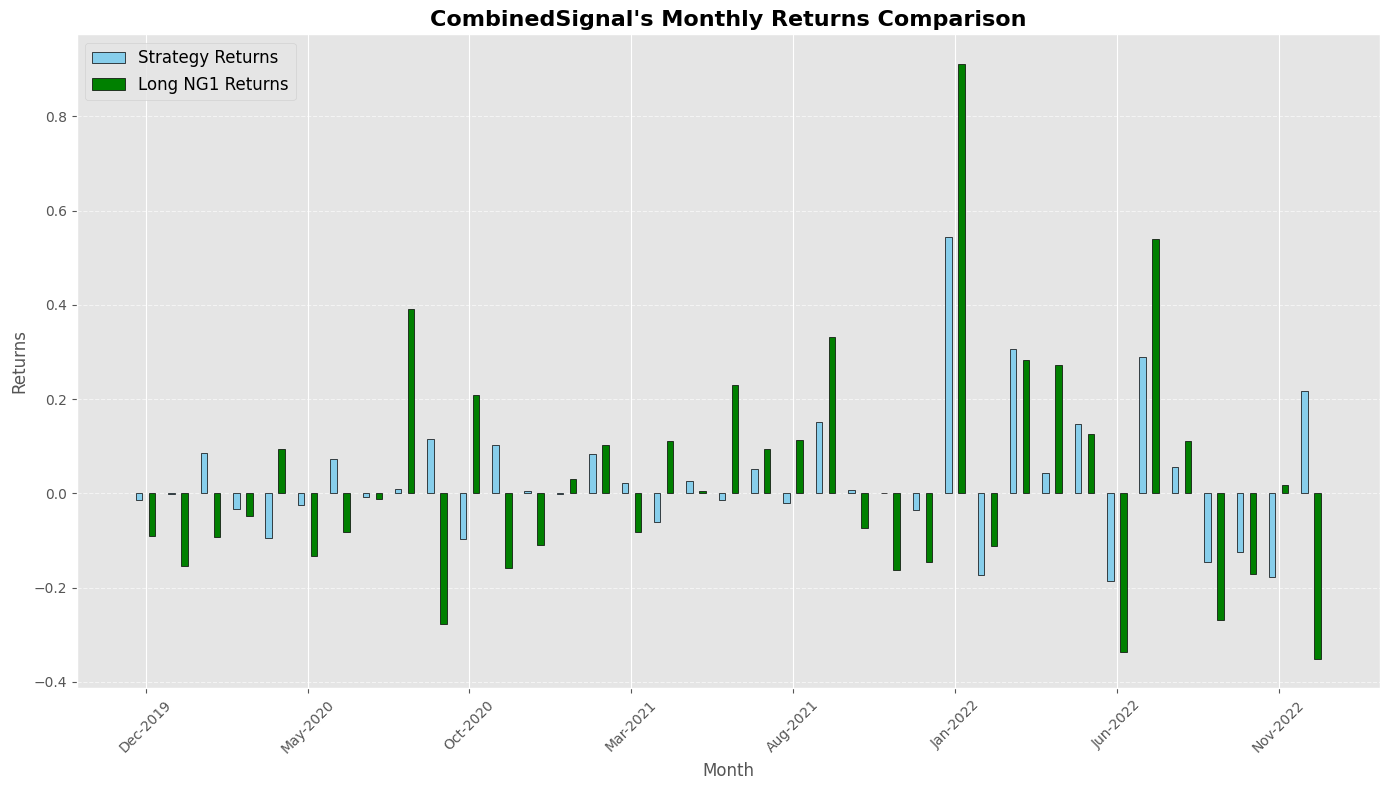

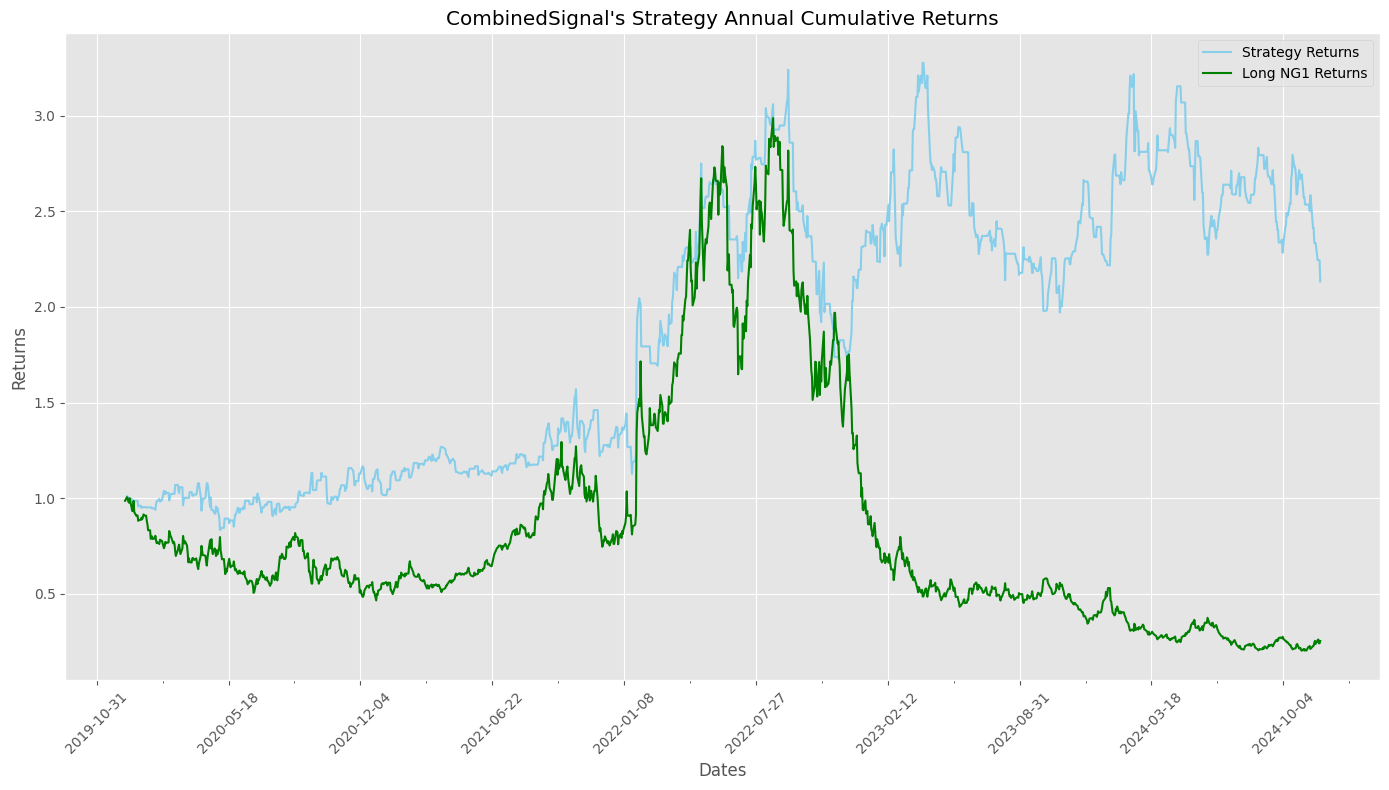

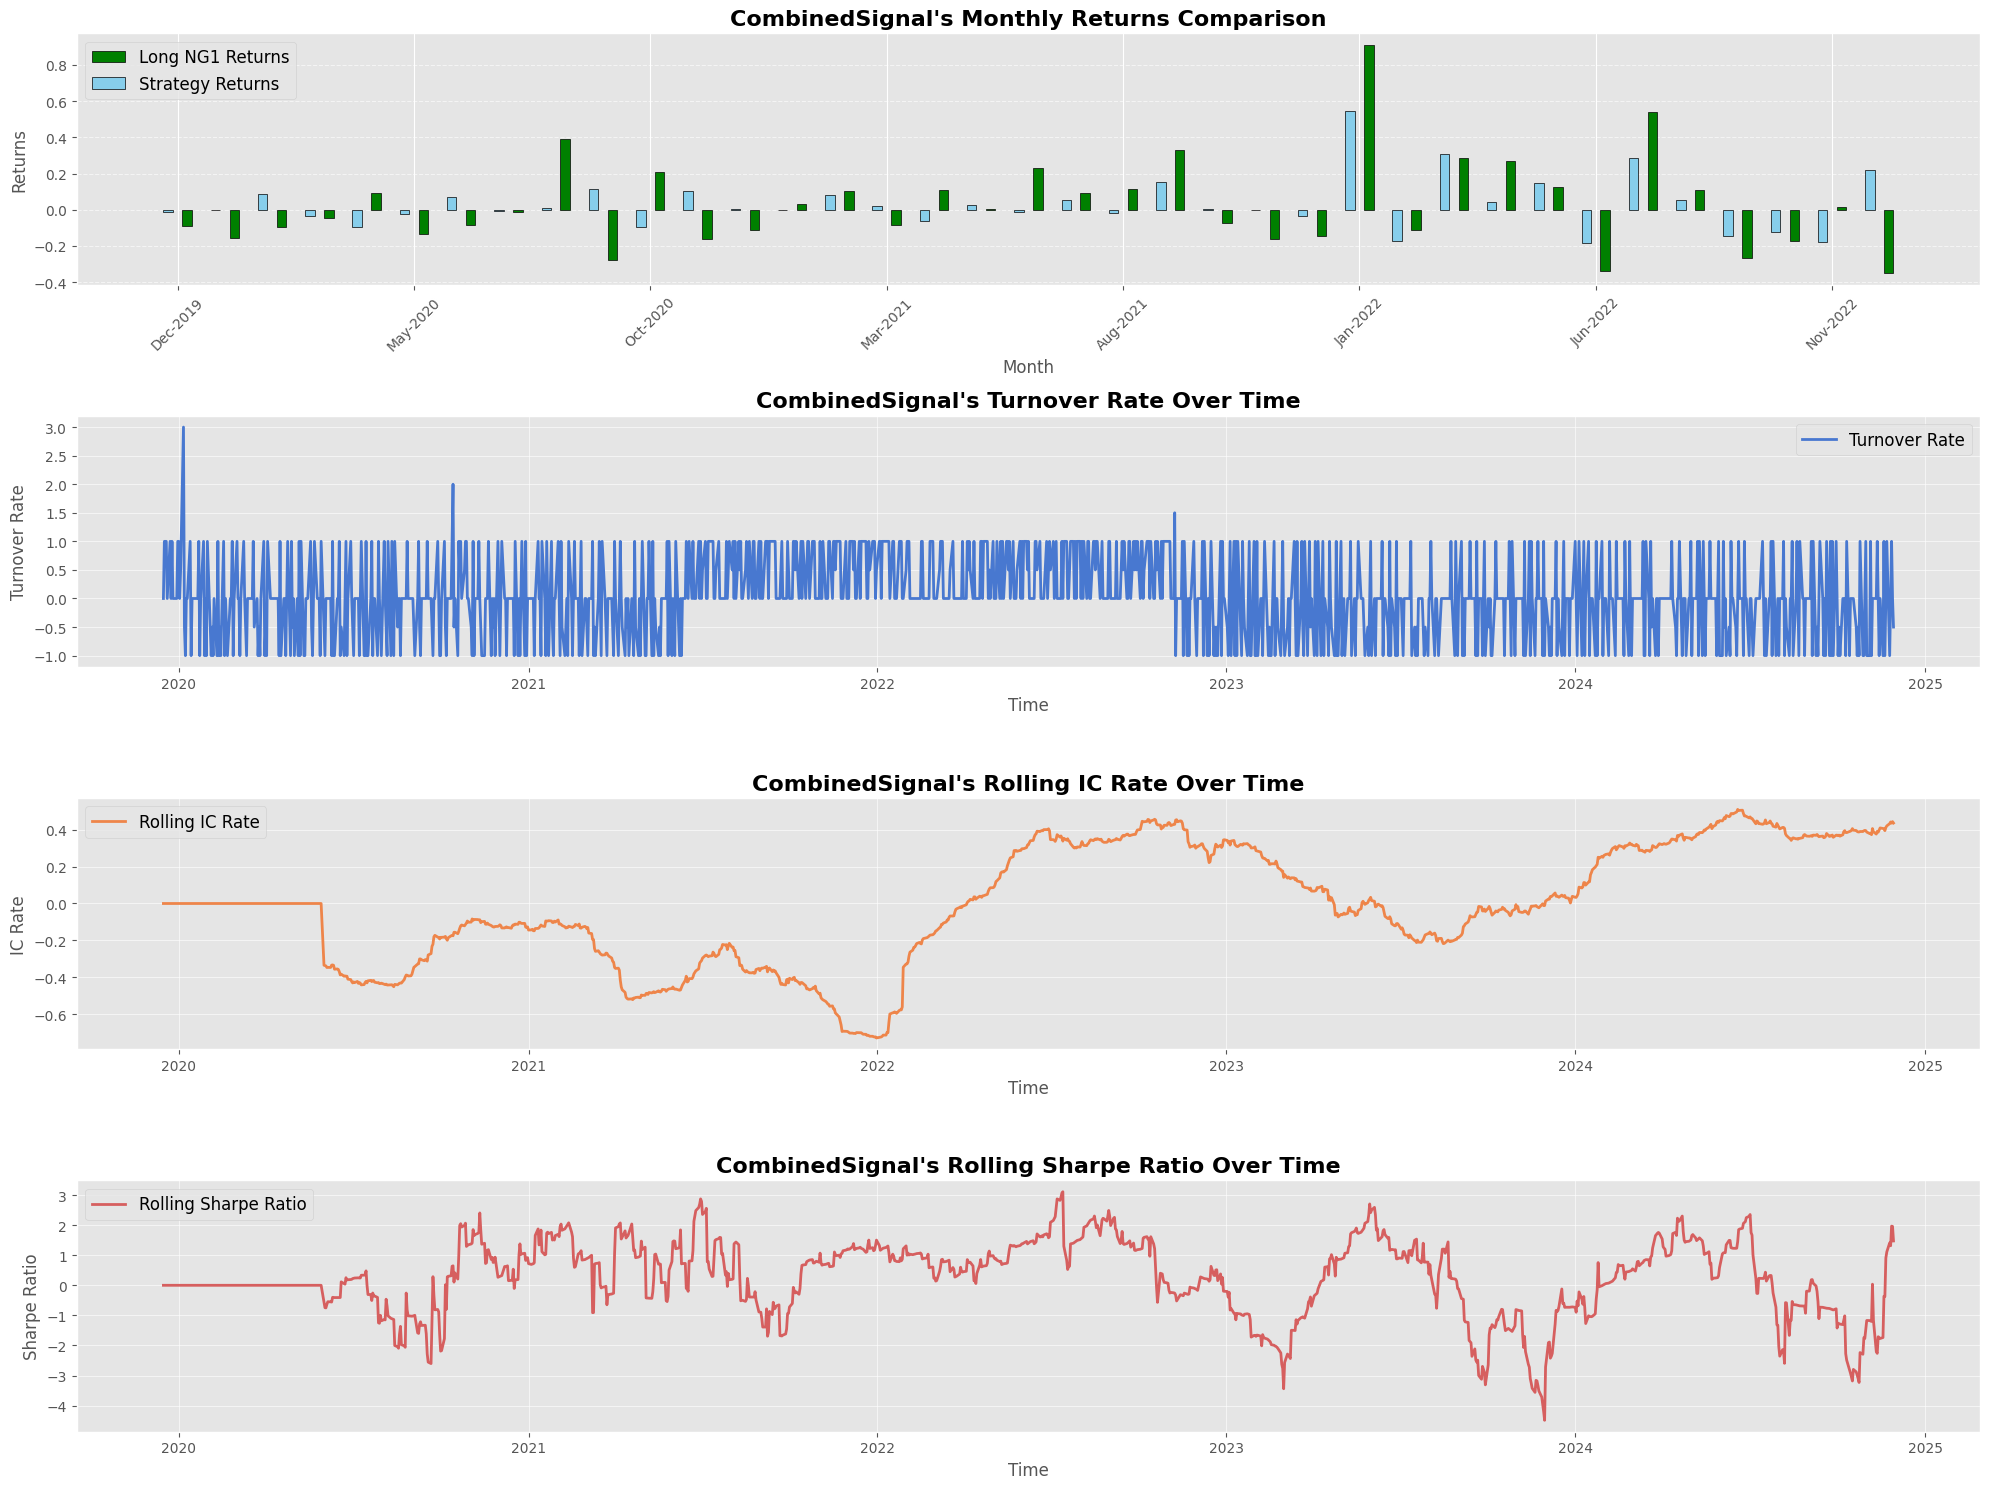

/Users/apple/anaconda3/envs/my-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


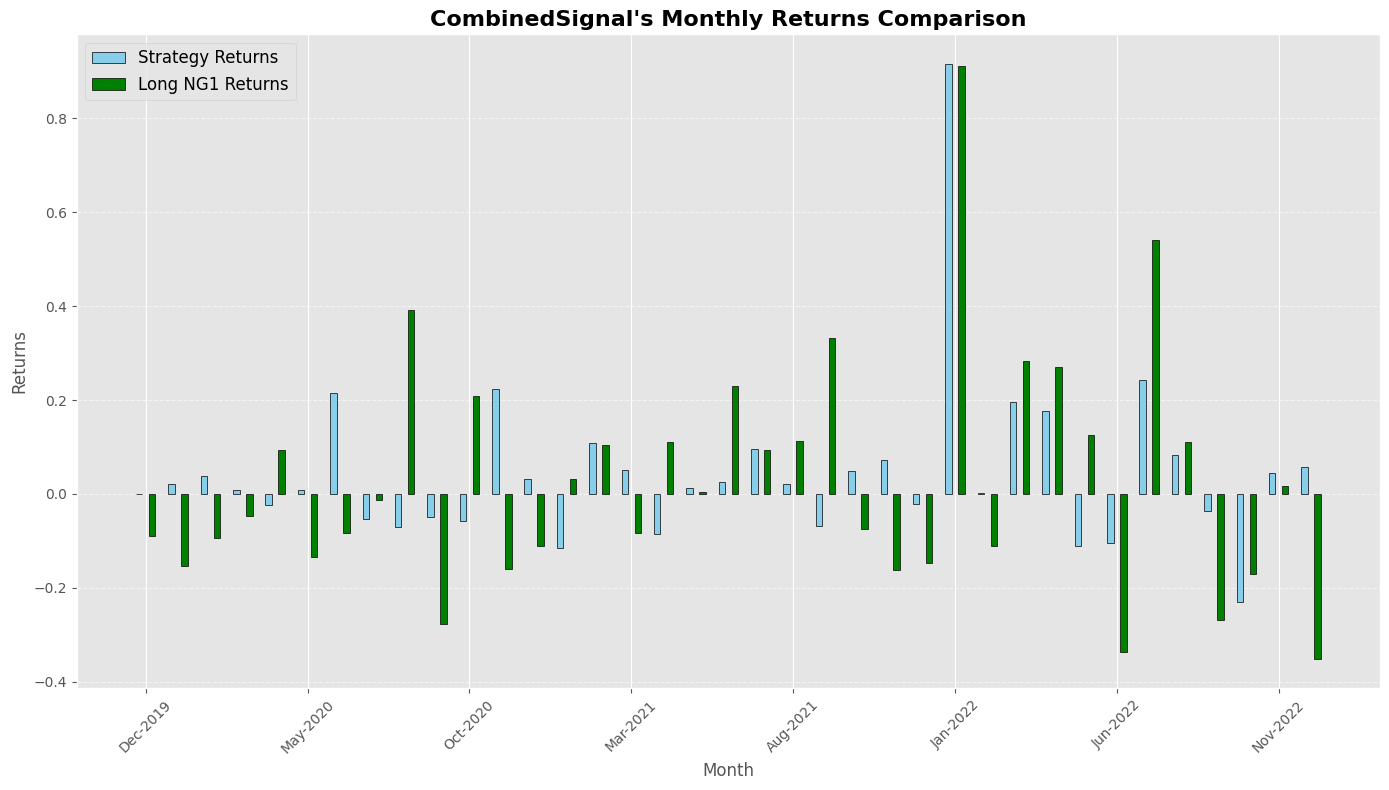

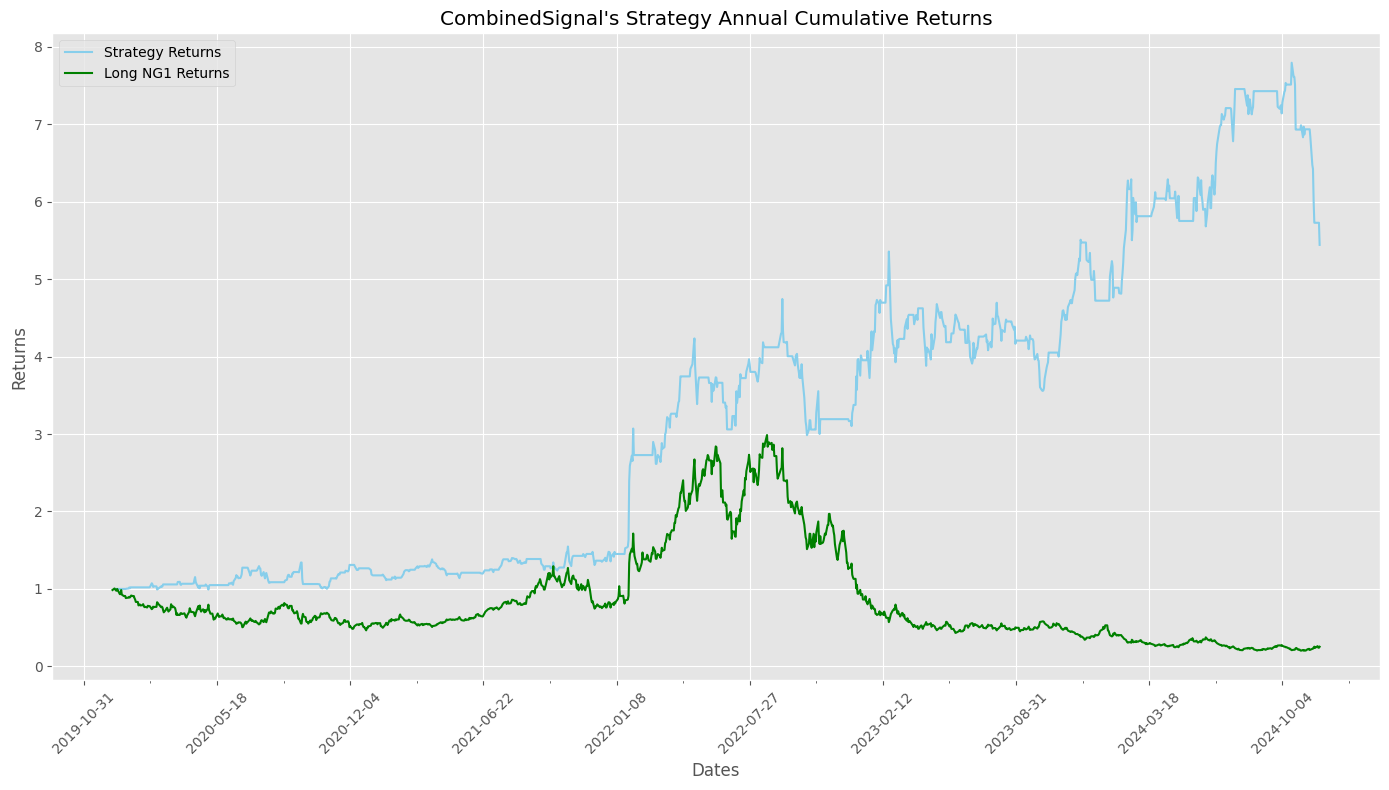

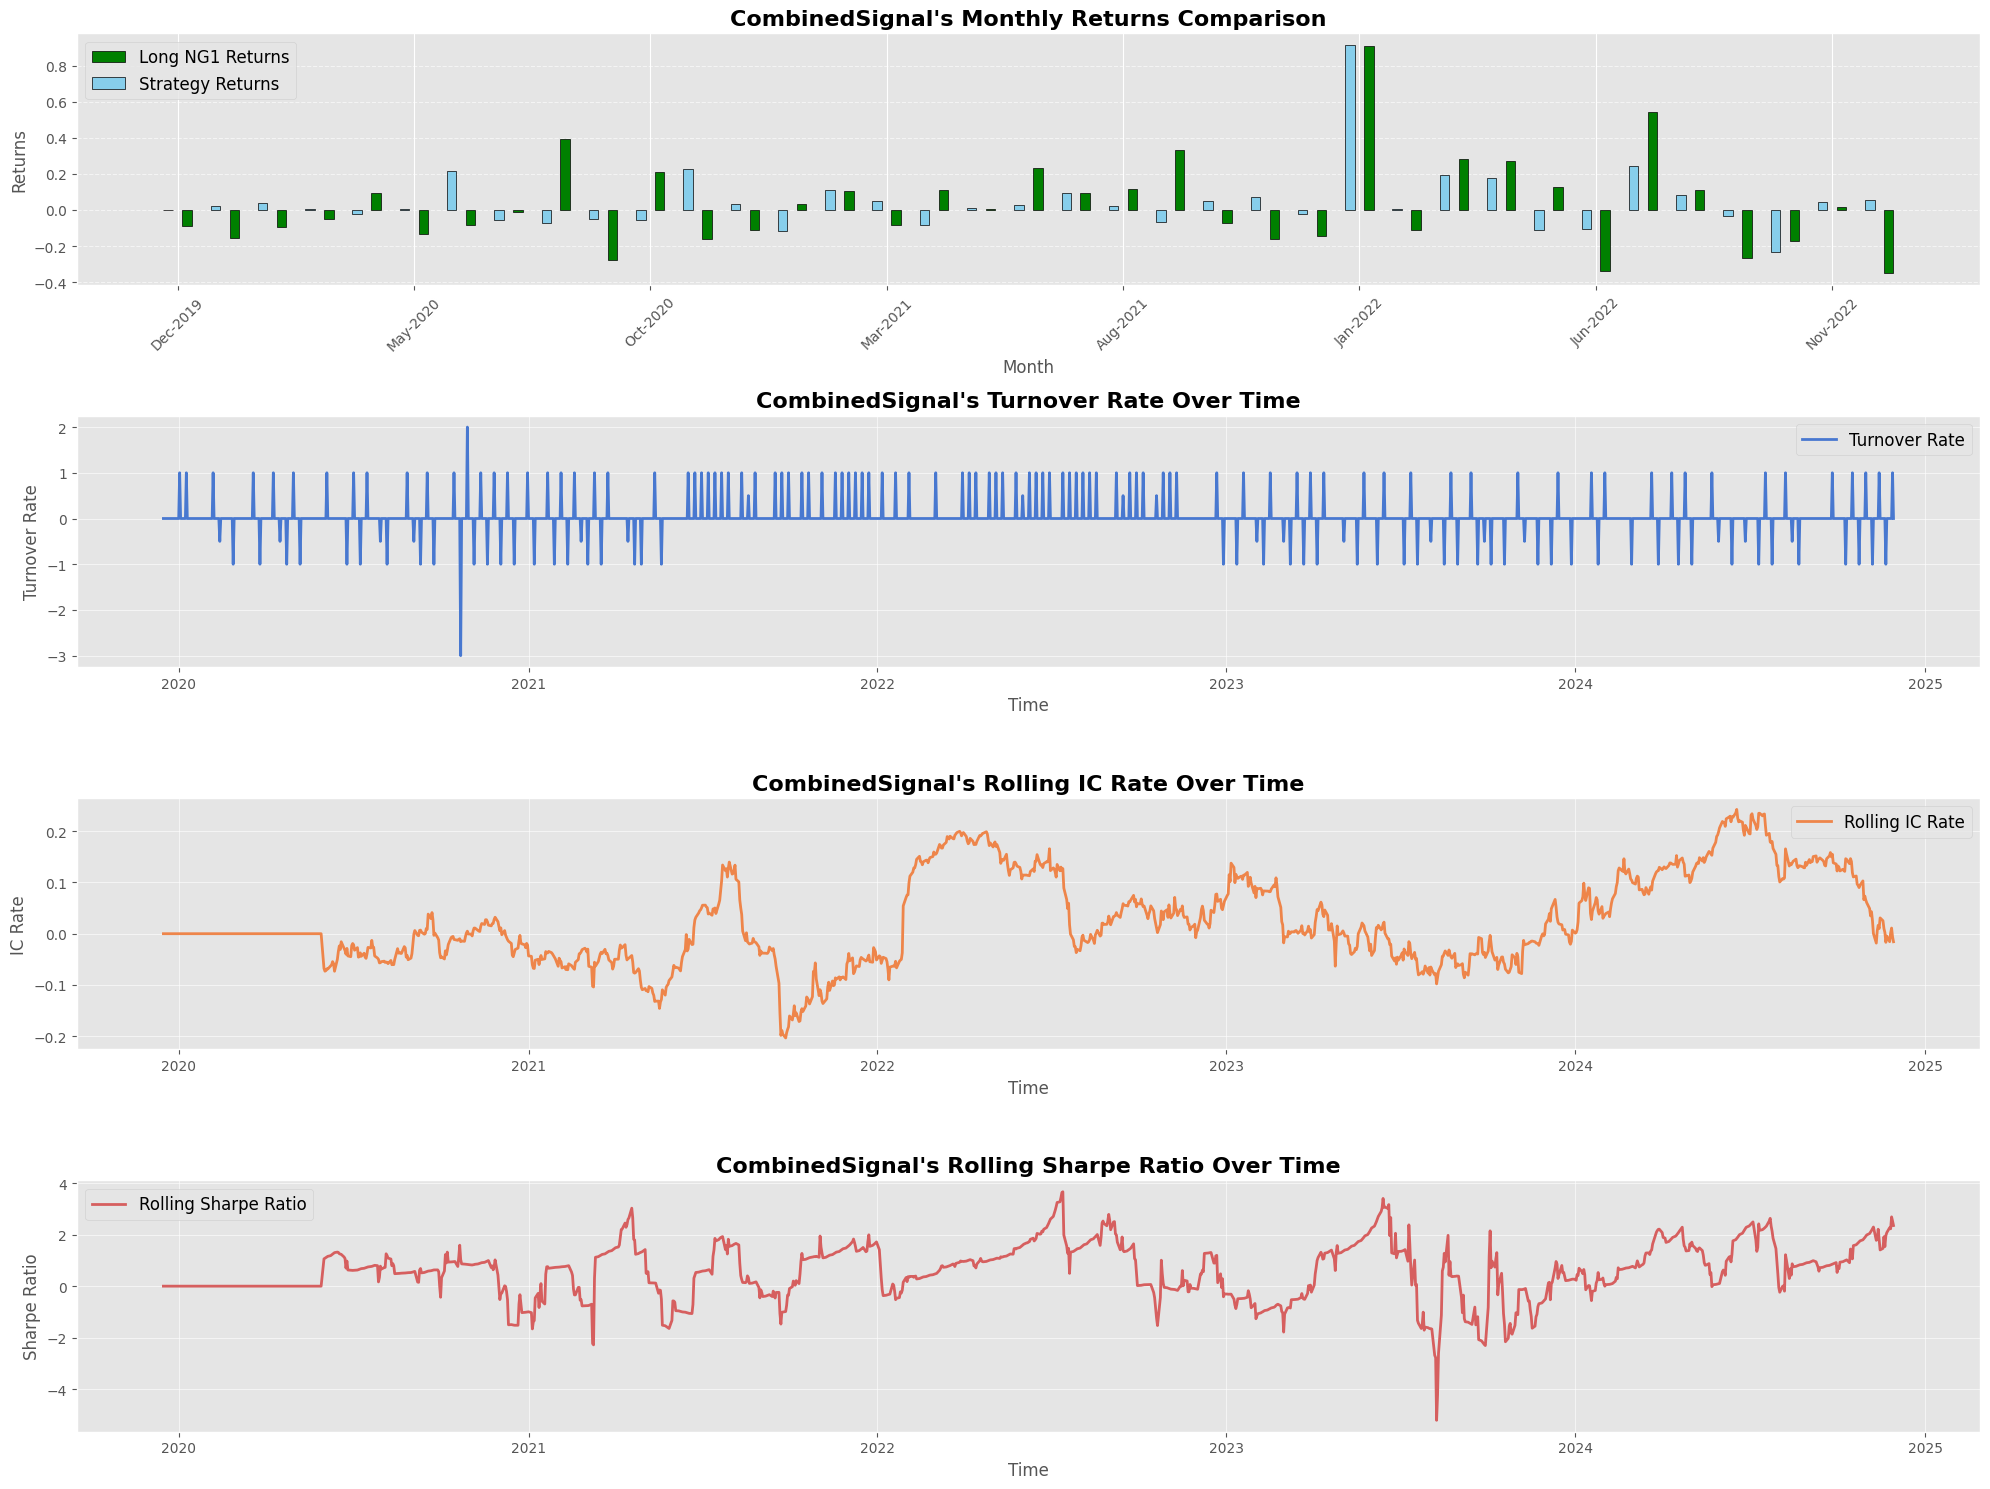

/Users/apple/anaconda3/envs/my-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


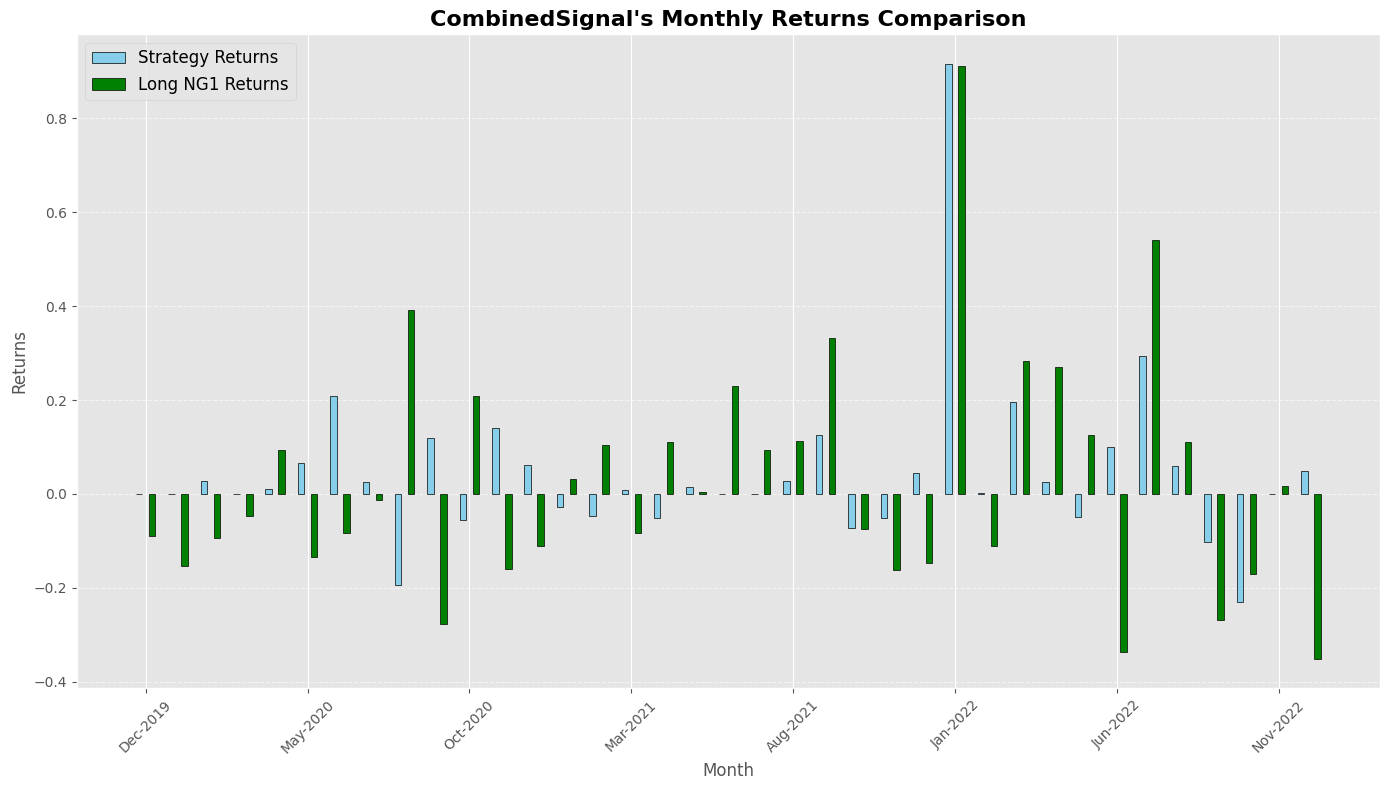

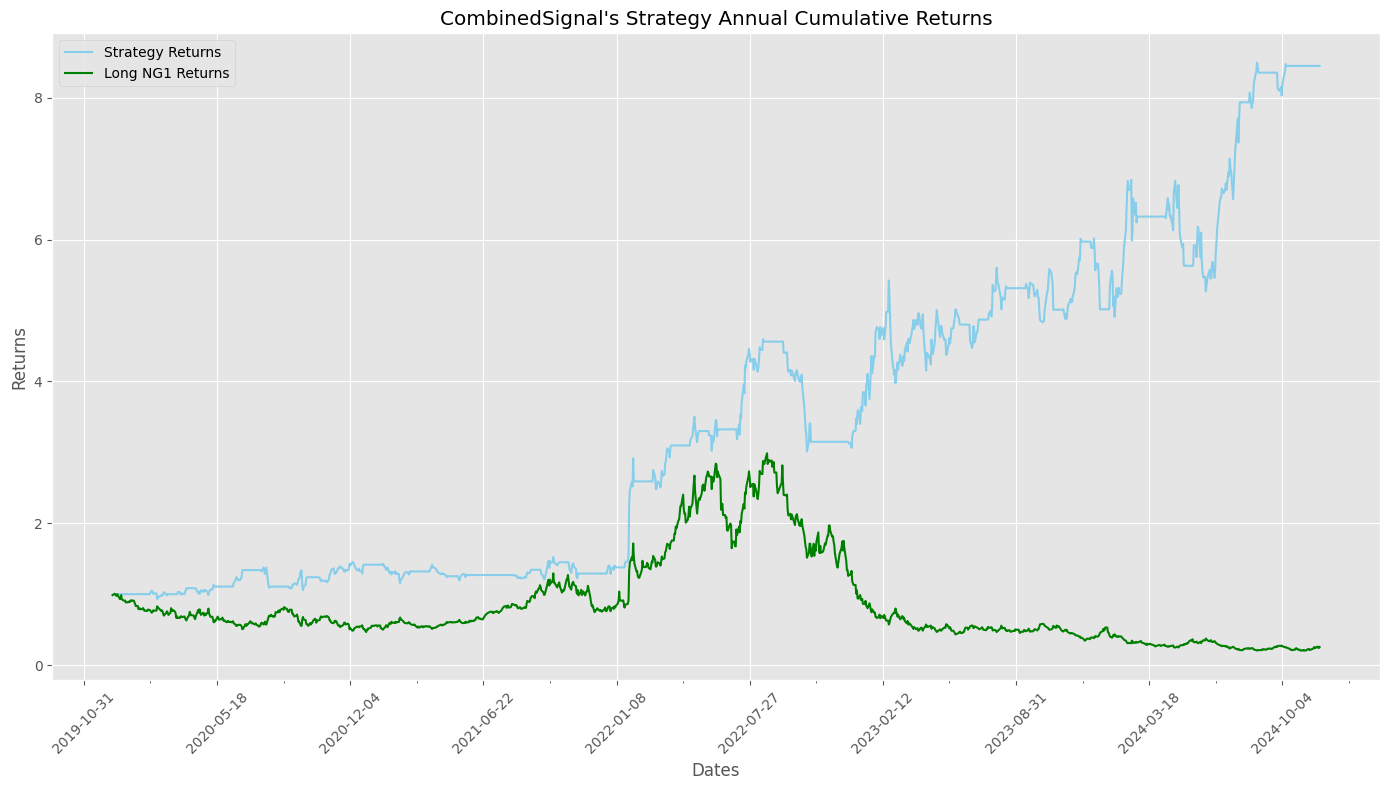

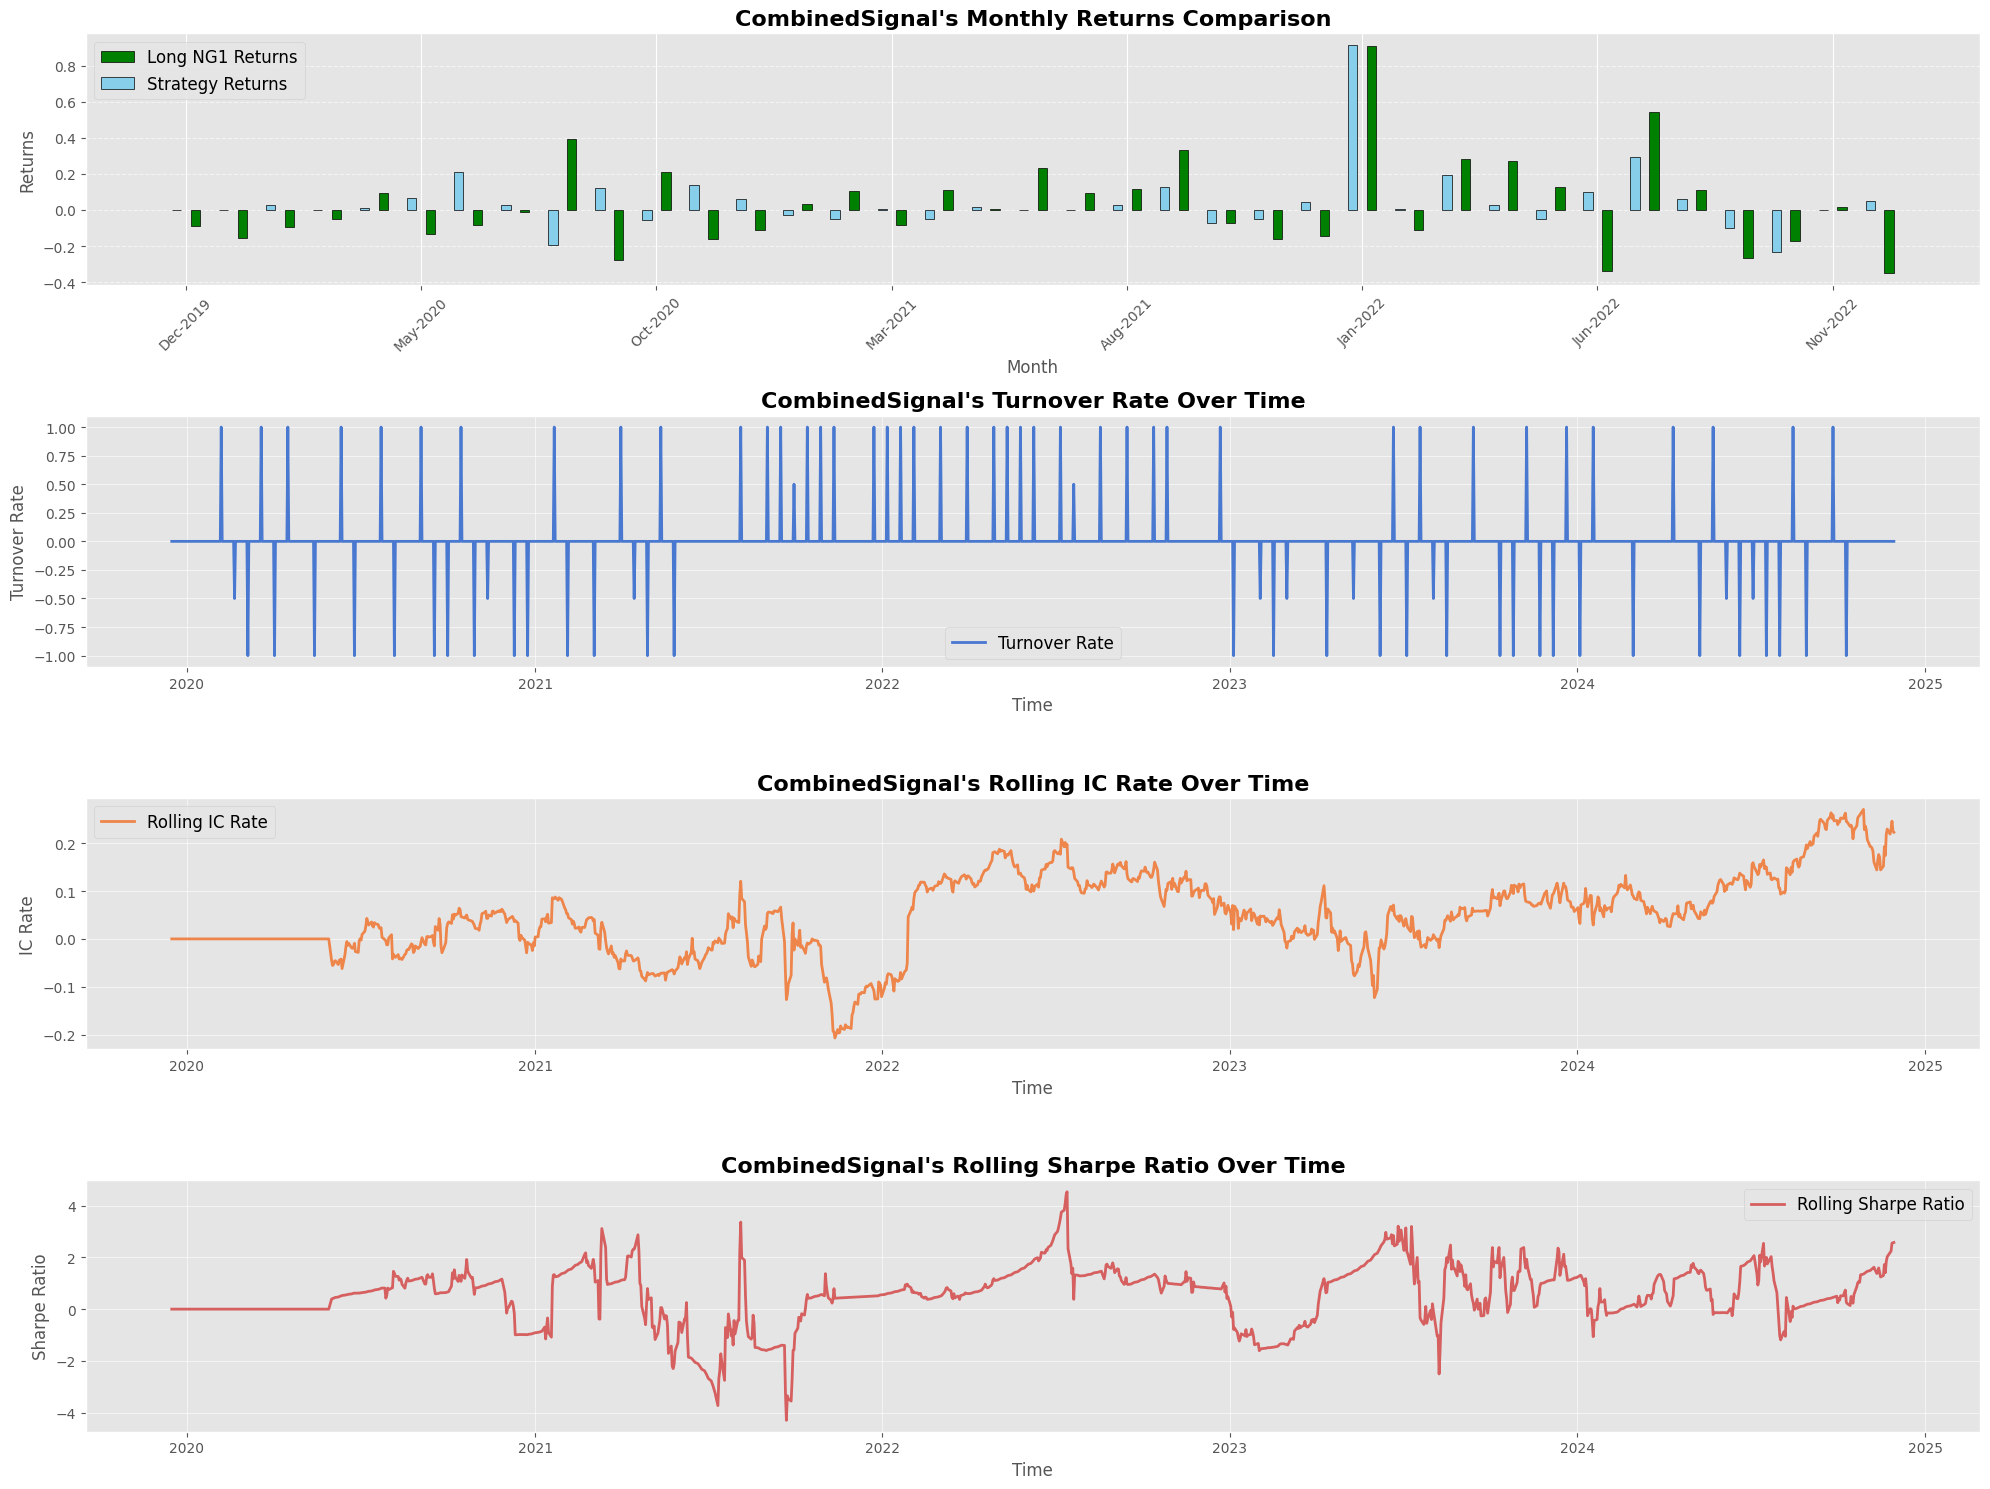

In [59]:
benchmark_path = '/Users/apple/Desktop/24fall/7841/Final_Project/UNG_data.csv'
benchmark = pd.read_csv(benchmark_path)[['Date','Close']]
benchmark['Date'] = pd.to_datetime(benchmark.Date.str[:10])
benchmark.rename(columns={'Date':'Dates'},inplace=True)
benchmark.set_index('Dates',inplace=True)

backtest1 = SingleFactorBacktester(prices, factor3, benchmark, 'CombinedSignal', start_value=100000, transaction_cost = 0.00016,
                    long_short = False, num_layers=5, short_ratio=0.2, long_ratio=0.2, holding_window=1,
                    rolling_window = 20, rf_rate = 0.02,start_date='2020-01-01', end_date='2024-11-29',Stop_Loss=True)

backtest2 =  SingleFactorBacktester(prices, factor3, benchmark, 'CombinedSignal', start_value=100000, transaction_cost = 0.00016,
                    long_short = False, num_layers=5, short_ratio=0.2, long_ratio=0.2, holding_window=5,
                    rolling_window = 20, rf_rate = 0.02,start_date='2020-01-01', end_date='2024-11-29',Stop_Loss=True)
backtest3 =  SingleFactorBacktester(prices, factor3, benchmark,'CombinedSignal', start_value=100000, transaction_cost = 0.00016,
                    long_short = False, num_layers=5, short_ratio=0.2, long_ratio=0.2, holding_window=10,
                    rolling_window = 20, rf_rate = 0.02,start_date='2020-01-01', end_date='2024-11-29',Stop_Loss=True)

backtest1.backtest()
backtest2.backtest()
backtest3.backtest()


In [58]:
te1 = pd.DataFrame(backtest1.performance_metrics)
te2 = pd.DataFrame(backtest2.performance_metrics)
te3 = pd.DataFrame(backtest3.performance_metrics)
pd.concat([te1,te2,te3])

,Factor Name,Holding Window,Strategy Annual Cumulative Return %,Long NG1 Annual Cumulative Return %,Excess Annual Cumulative Return %,Strategy Annual Sharpe Ratio,Long NG1 Sharpe Ratio,Strategy Annual Volatility,Long NG1 Annual Volatility,Max Drawdown %,Win Rate %,Annual Sortino Ratio,Information Coefficient (IC),Information Ratio (IR),Turnover Rate
0,CombinedSignal,1,15.881449,-4.558111,-0.105237,0.296637,0.15249,0.467781,0.621804,-49.172194,30.579151,0.715561,0.052309,0.358316,0.049807
0,CombinedSignal,5,39.054509,-4.558111,9.761591,0.819612,0.15249,0.451923,0.621804,-37.073619,28.494208,1.109206,0.052309,0.570288,0.029730
0,CombinedSignal,10,51.485566,-4.558111,6.853187,1.108341,0.15249,0.446311,0.621804,-34.484944,28.571429,1.361321,0.052309,0.519588,0.005019


# Result From 2006  to 2024

/Users/apple/anaconda3/envs/my-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


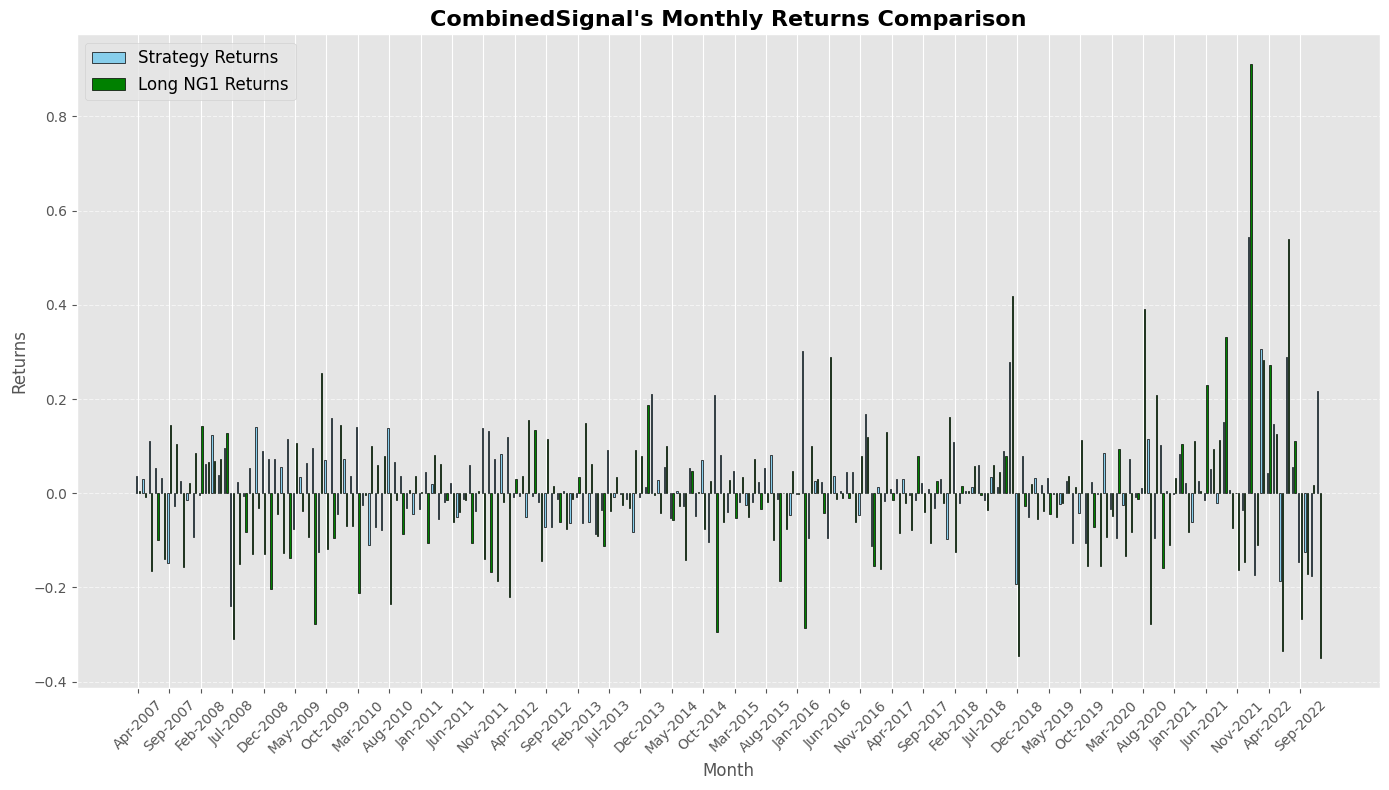

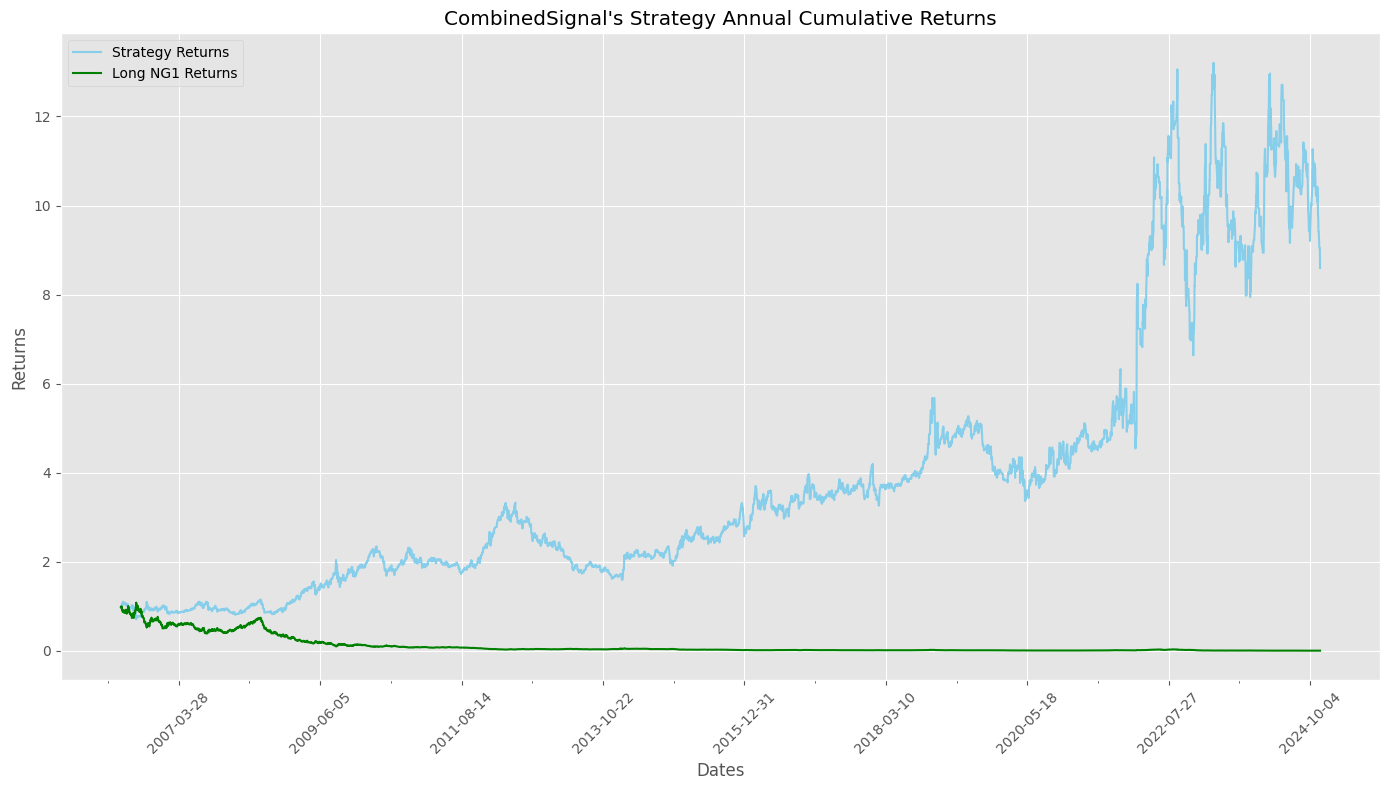

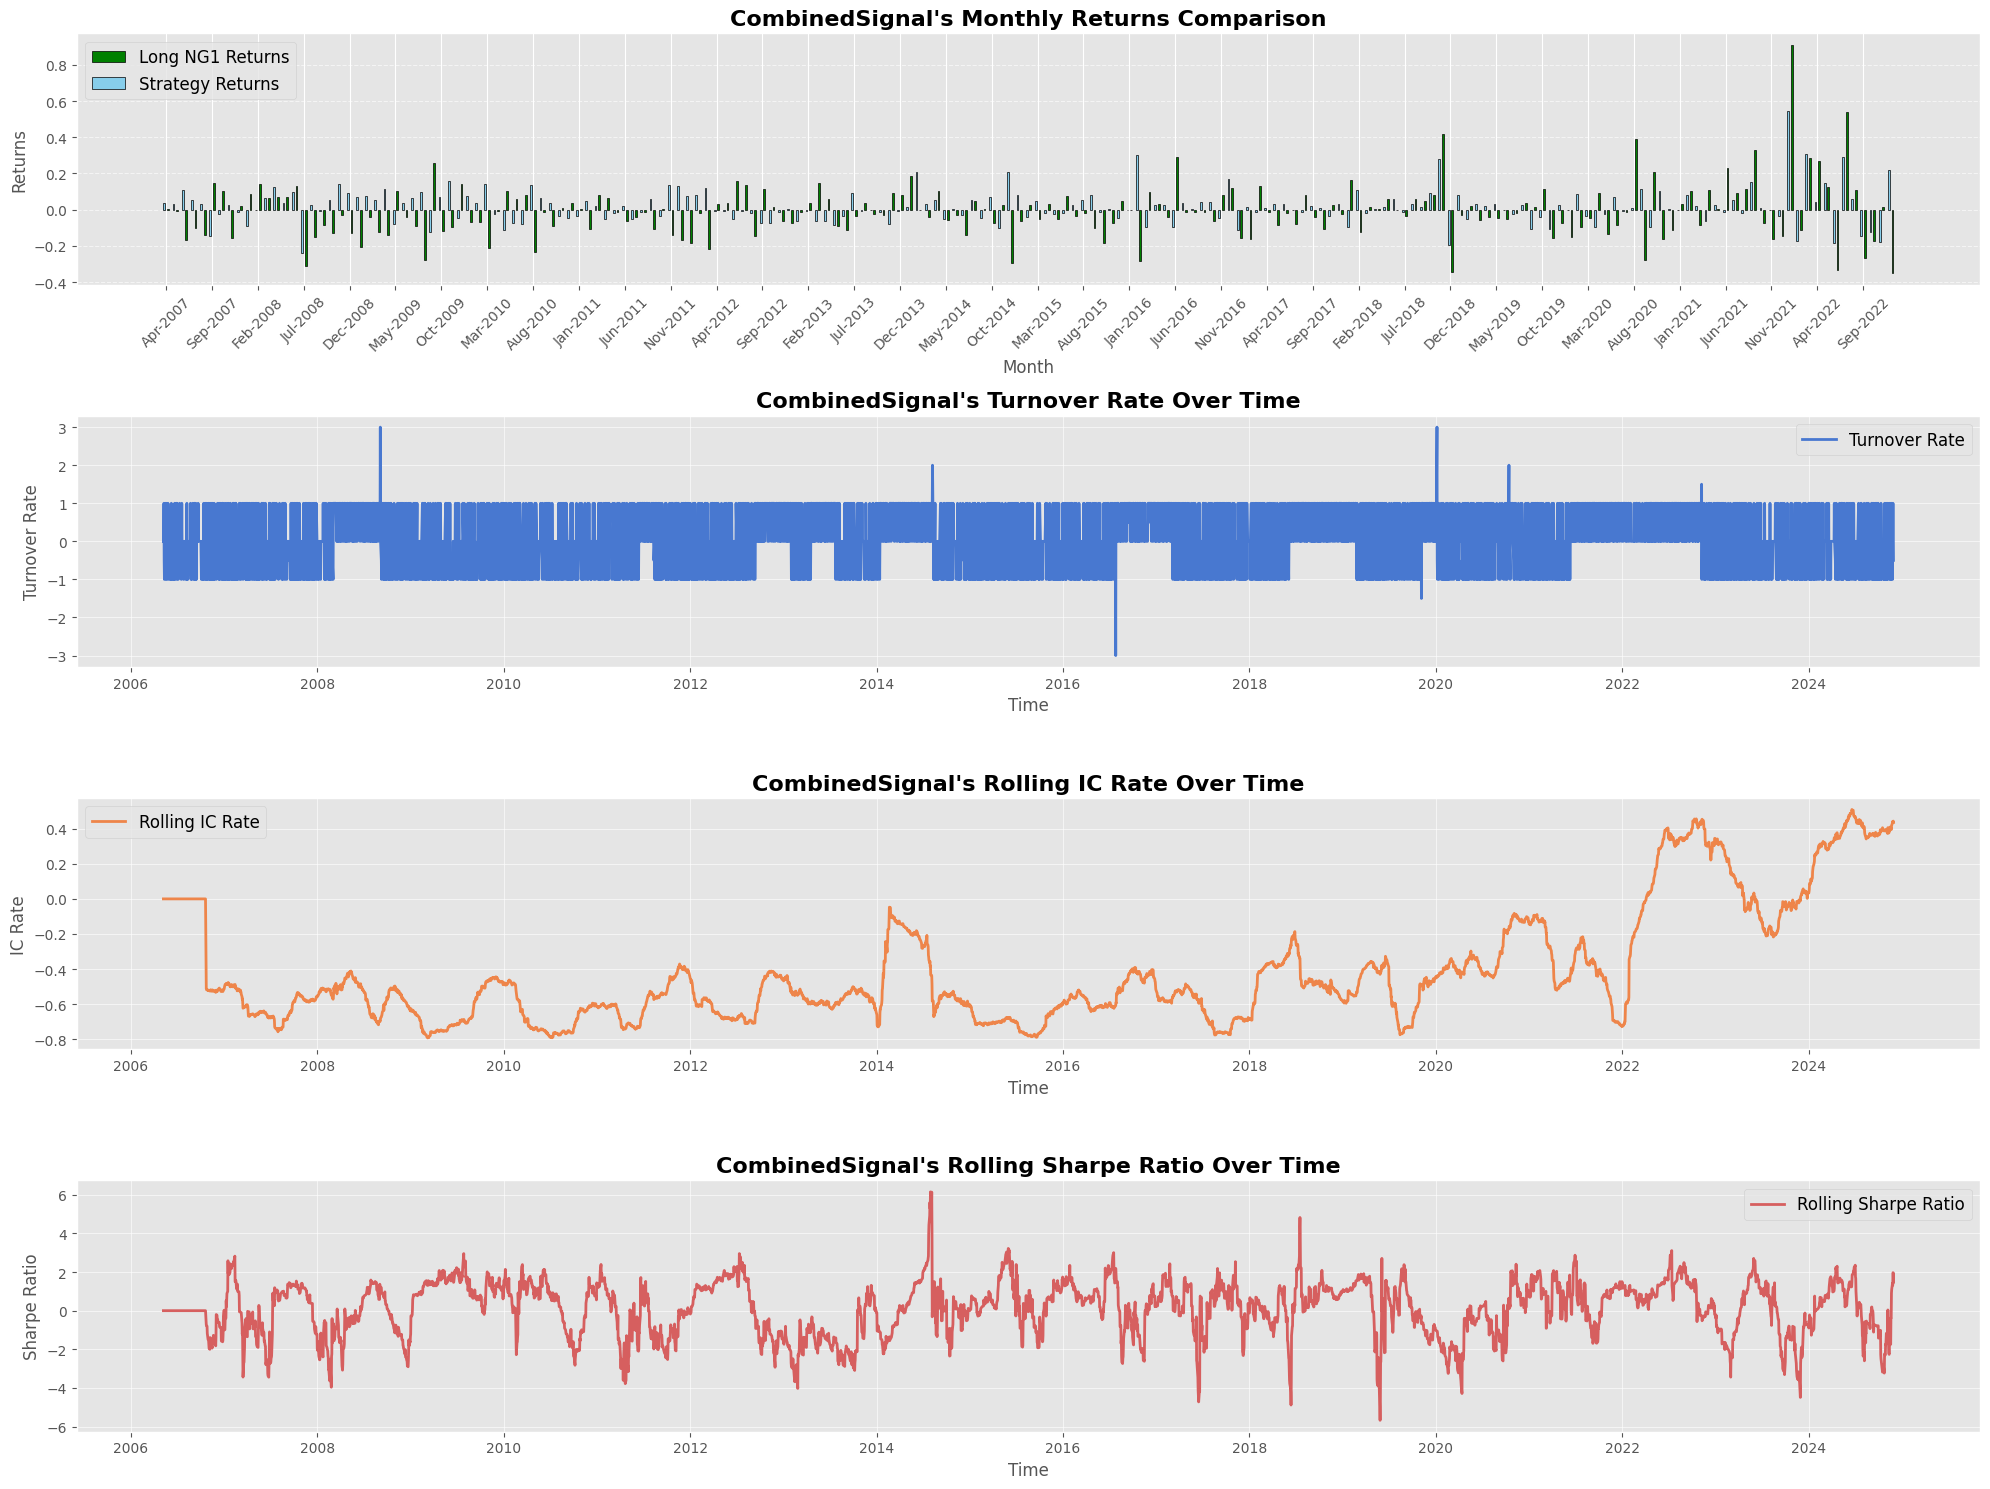

/Users/apple/anaconda3/envs/my-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


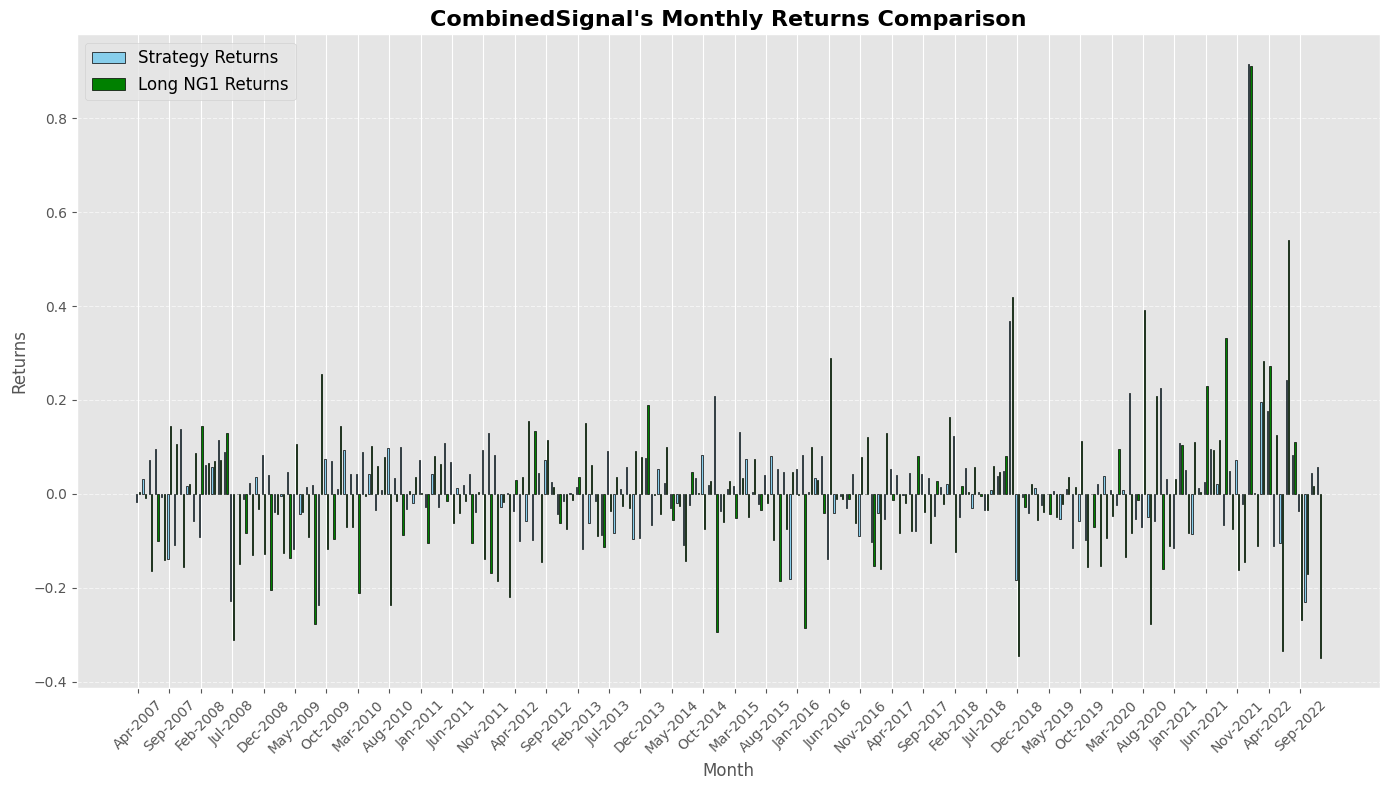

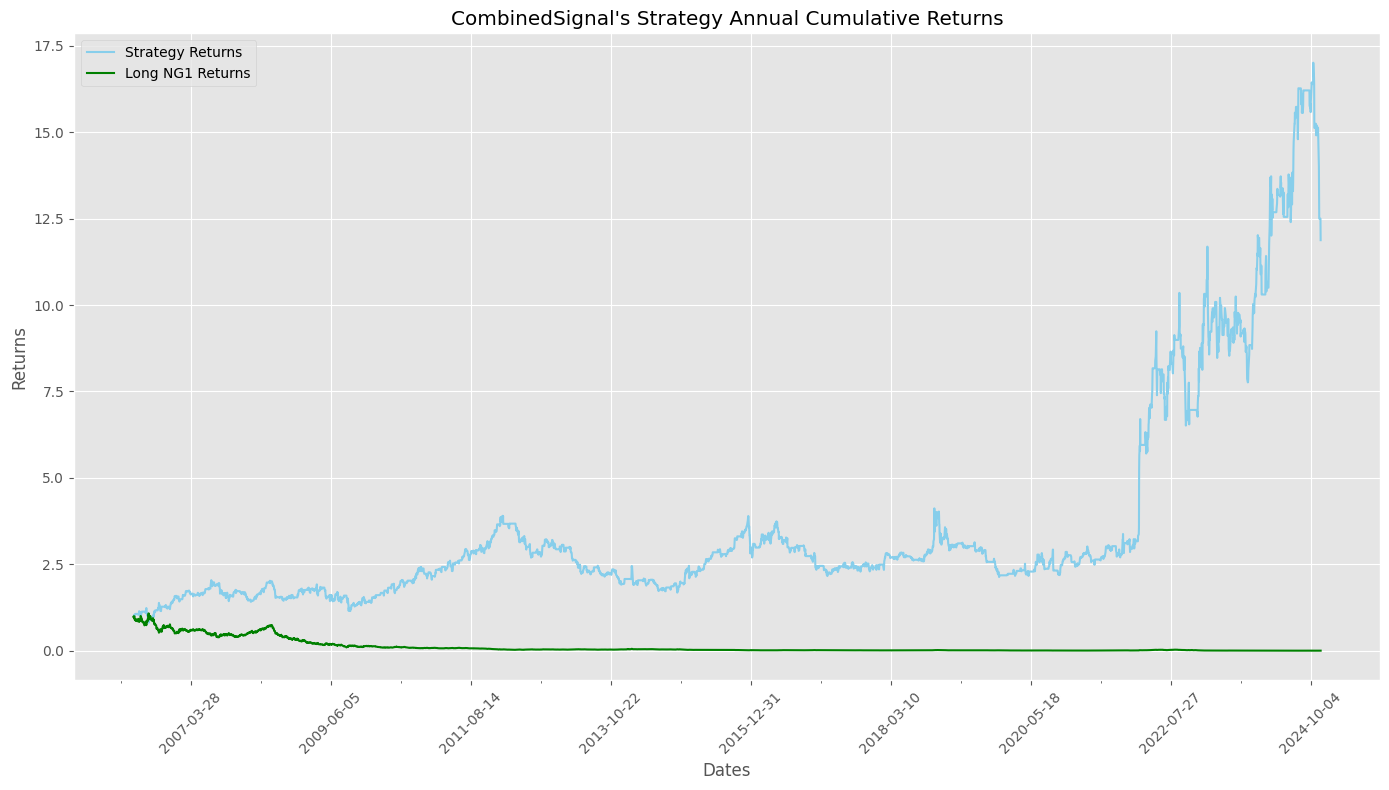

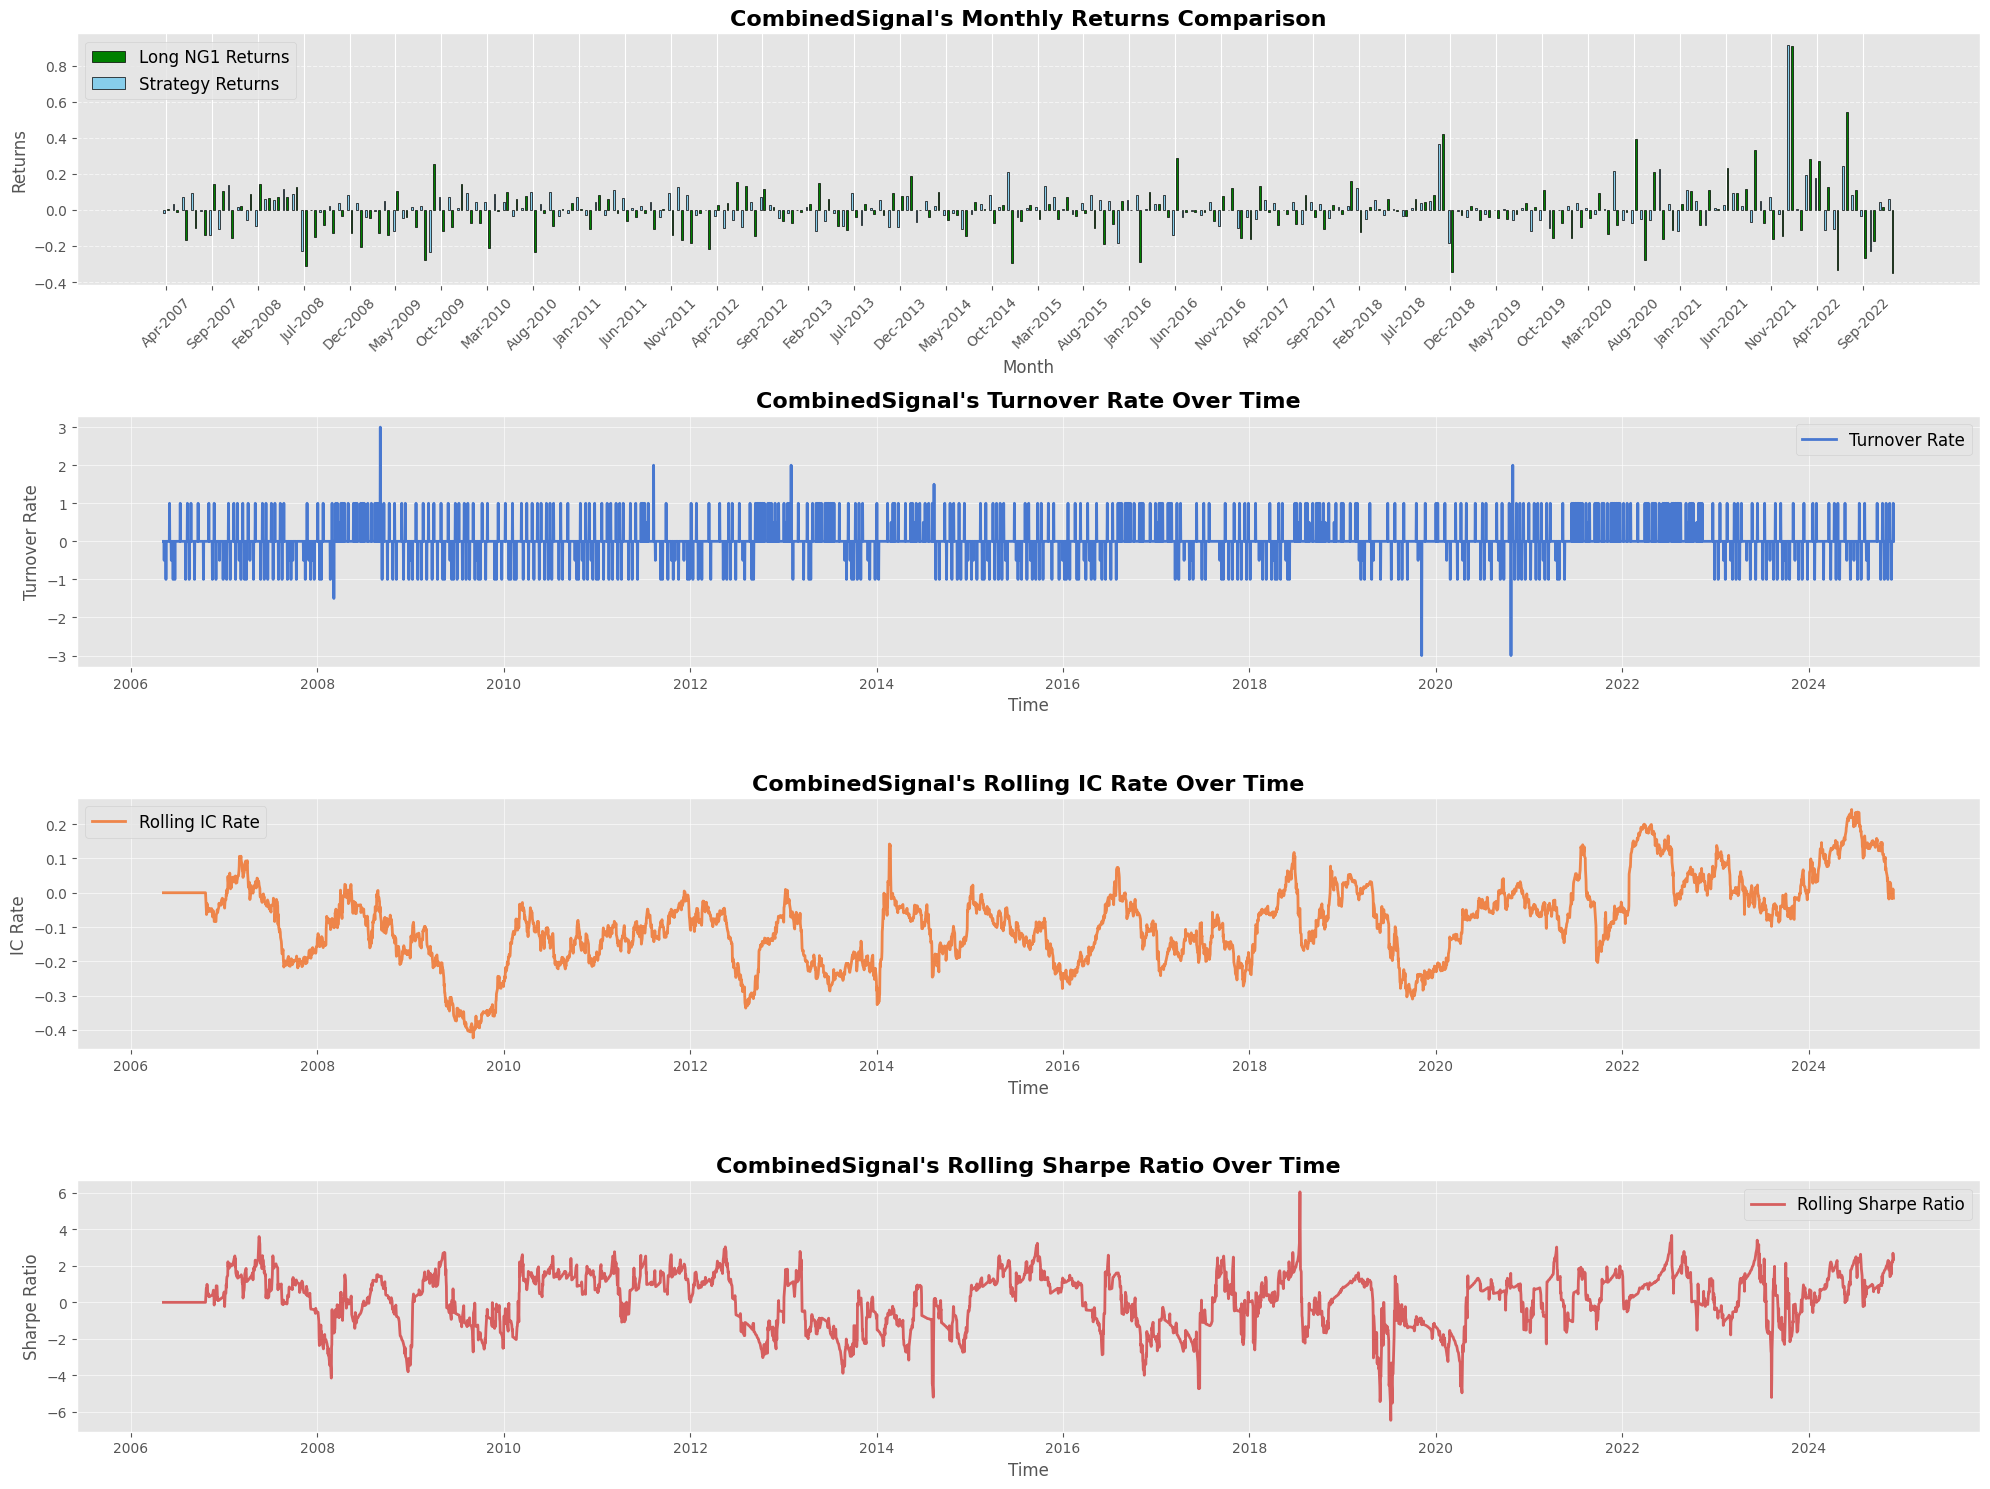

/Users/apple/anaconda3/envs/my-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


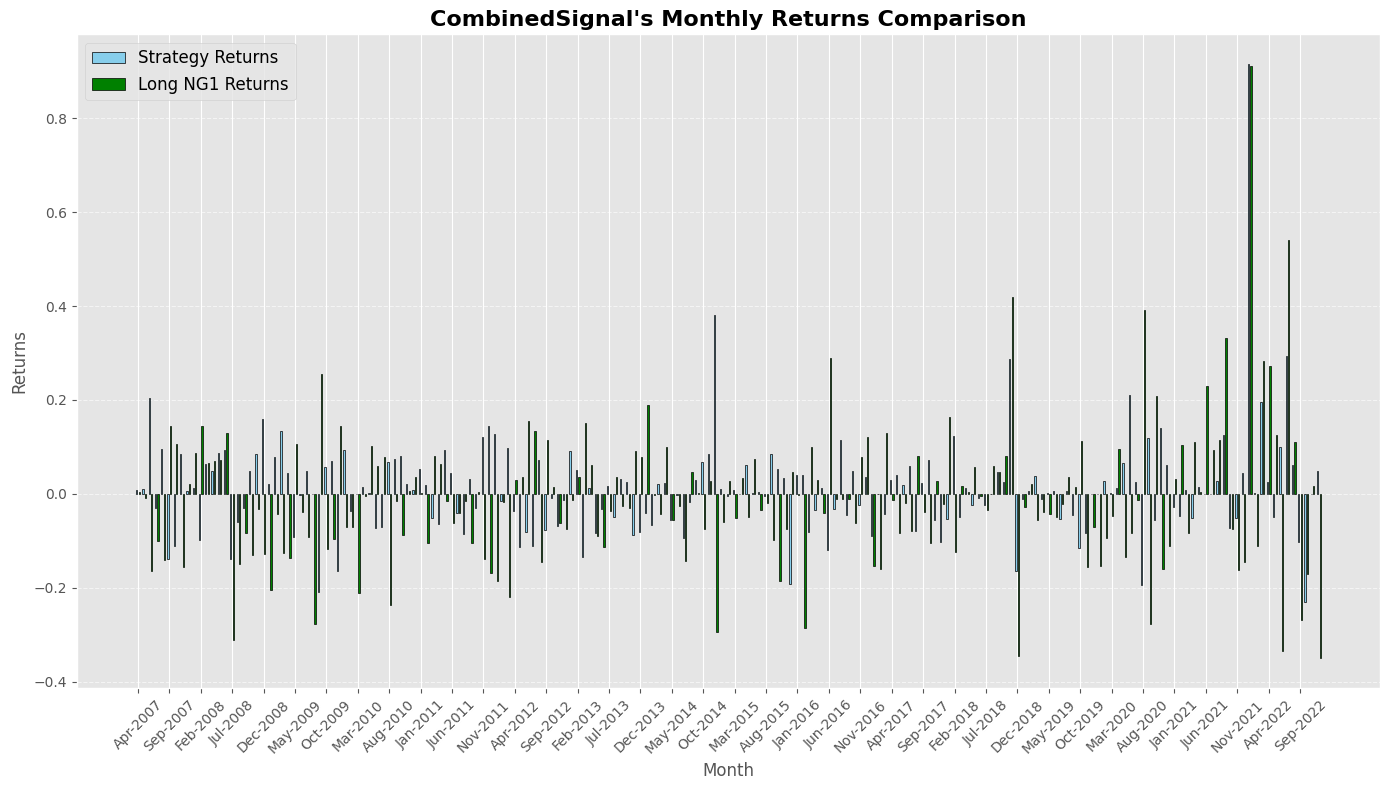

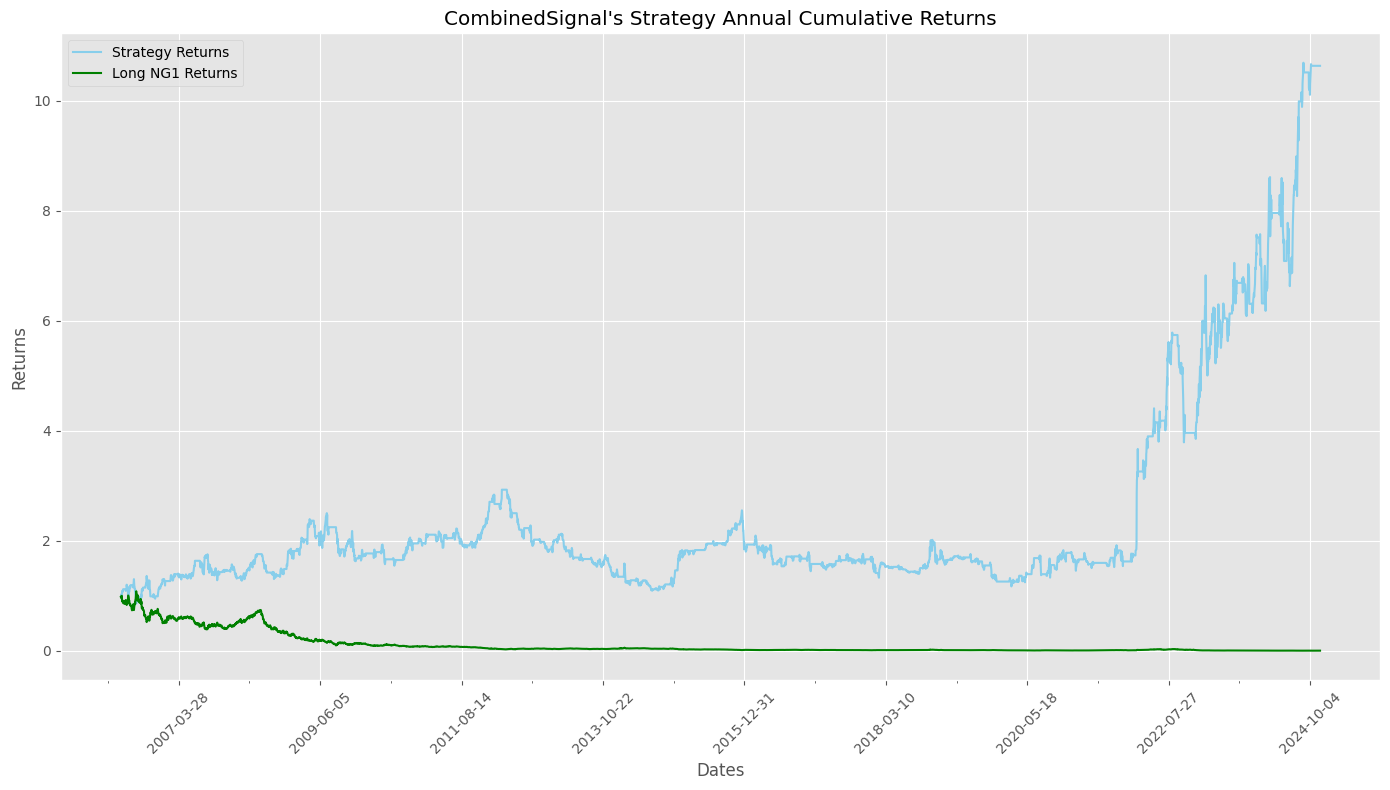

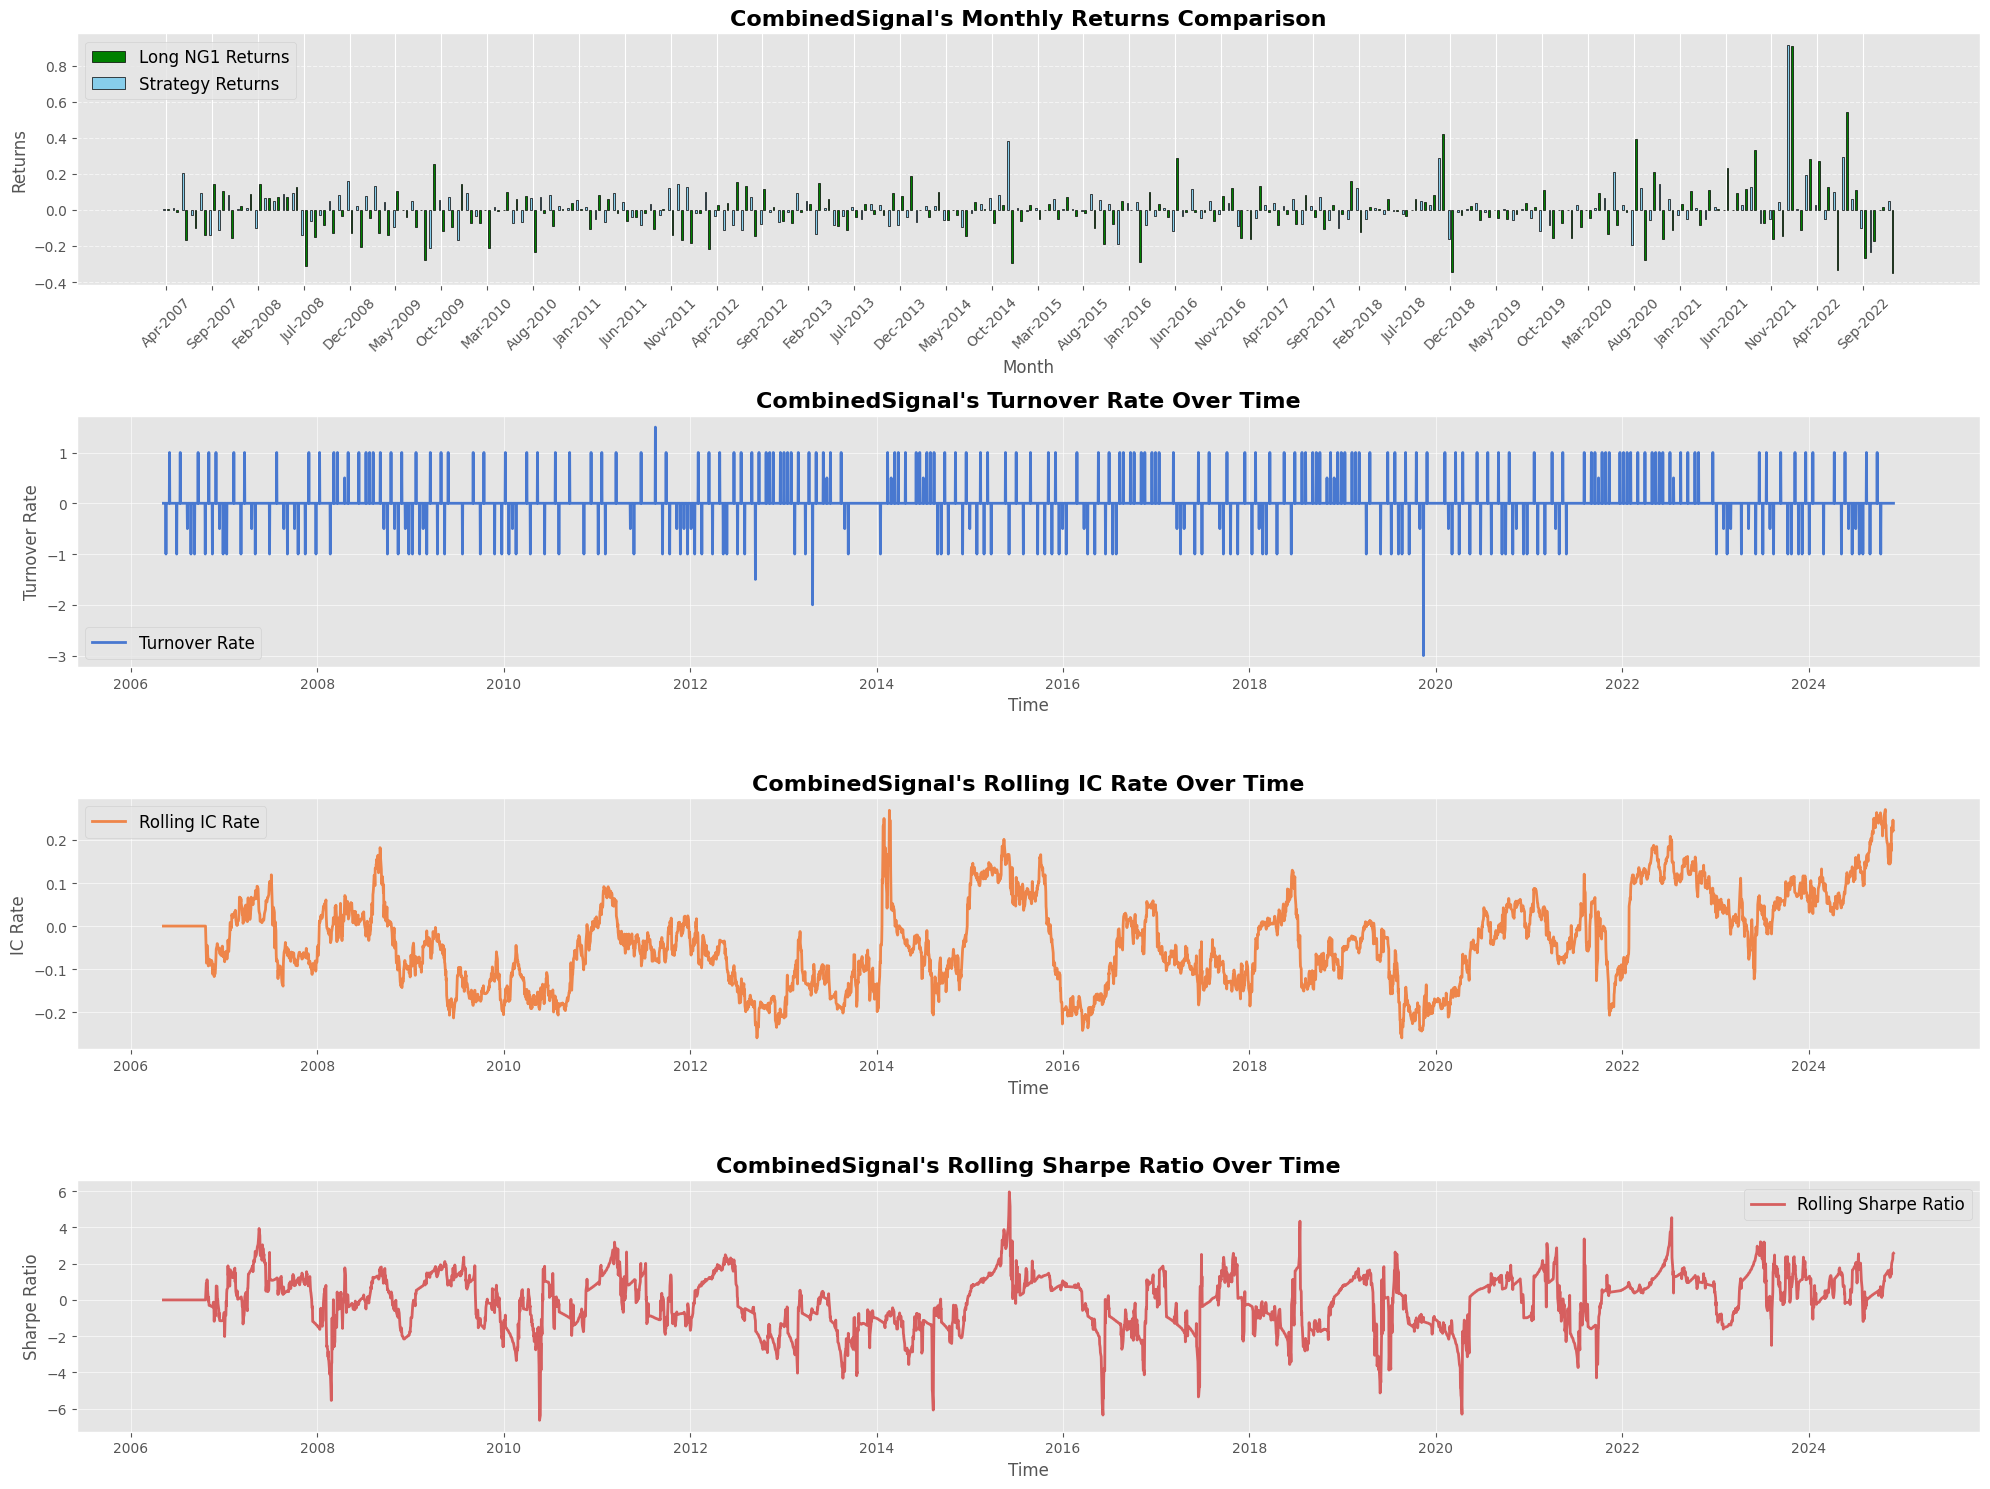

In [76]:
benchmark_path = '/Users/apple/Desktop/24fall/7841/Final_Project/UNG_data.csv'
benchmark = pd.read_csv(benchmark_path)[['Date','Close']]
benchmark['Date'] = pd.to_datetime(benchmark.Date.str[:10])
benchmark.rename(columns={'Date':'Dates'},inplace=True)
benchmark.set_index('Dates',inplace=True)

backtest4 = SingleFactorBacktester(prices, factor3, benchmark, 'CombinedSignal', start_value=100000, transaction_cost = 0.00016,
                    long_short = False, num_layers=5, short_ratio=0.2, long_ratio=0.2, holding_window=1,
                    rolling_window = 20, rf_rate = 0.02,start_date='2006-05-24', end_date='2024-11-29',Stop_Loss=True)

backtest5 =  SingleFactorBacktester(prices, factor3, benchmark, 'CombinedSignal', start_value=100000, transaction_cost = 0.00016,
                    long_short = False, num_layers=5, short_ratio=0.2, long_ratio=0.2, holding_window=5,
                    rolling_window = 20, rf_rate = 0.02,start_date='2006-05-24', end_date='2024-11-29',Stop_Loss=True)
backtest6 =  SingleFactorBacktester(prices, factor3, benchmark,'CombinedSignal', start_value=100000, transaction_cost = 0.00016,
                    long_short = False, num_layers=5, short_ratio=0.2, long_ratio=0.2, holding_window=10,
                    rolling_window = 20, rf_rate = 0.02,start_date='2006-05-24', end_date='2024-11-29',Stop_Loss=True)

backtest4.backtest()
backtest5.backtest()
backtest6.backtest()

In [61]:
te1 = pd.DataFrame(backtest4.performance_metrics)
te2 = pd.DataFrame(backtest5.performance_metrics)
te3 = pd.DataFrame(backtest6.performance_metrics)
pd.concat([te1,te2,te3])

,Factor Name,Holding Window,Strategy Annual Cumulative Return %,Long NG1 Annual Cumulative Return %,Excess Annual Cumulative Return %,Strategy Annual Sharpe Ratio,Long NG1 Sharpe Ratio,Strategy Annual Volatility,Long NG1 Annual Volatility,Max Drawdown %,Win Rate %,Annual Sortino Ratio,Information Coefficient (IC),Information Ratio (IR),Turnover Rate
0,CombinedSignal,1,12.059369,-21.865858,18.310553,0.285163,-0.462233,0.352723,0.464235,-52.002895,31.765677,0.620890,-0.244577,0.643645,0.019802
0,CombinedSignal,5,6.331892,-21.865858,10.146328,0.121999,-0.462233,0.355040,0.464235,-63.926583,30.507426,0.368488,-0.244577,0.507241,0.010314
0,CombinedSignal,10,6.397621,-21.865858,11.672177,0.122289,-0.462233,0.359573,0.464235,-59.670933,32.157591,0.382801,-0.244577,0.533944,0.005569
